# Signal Validation: ggH → H → Za (NanoAODv15)

Validation plots for the locally produced NanoAODv15 signal sample with CMSSW.

**Signal process:** $gg \to H(125) \to Z(\to \ell^+\ell^-) + a(\to \text{tracks})$ at $\sqrt{s} = 13.6$ TeV

Uses `uproot` + `awkward` for columnar analysis and `mplhep` for CMS-style plotting.

In [16]:
import sys
!{sys.executable} -m pip install -U awkward uproot vector hist mplhep > /dev/null 2>&1

In [17]:
import uproot
import awkward as ak
import numpy as np
import vector
import hist
import matplotlib.pyplot as plt
import mplhep as hep
from glob import glob
import gc

# Print versions for reproducibility
for mod in [uproot, ak, np, vector, hist, hep]:
    print(f"{mod.__name__:12s} {mod.__version__}")

vector.register_awkward()

uproot       5.7.1
awkward      2.9.0
numpy        2.4.2
vector       1.8.0
hist         2.10.1
mplhep       1.1.0


In [18]:
# ── CMS plot style & configuration ─────────────────────────────────────────────
hep.style.use(hep.style.CMS)
plt.rcParams.update({"figure.figsize": (10, 8), "font.size": 16})

LUMI_TEXT = ""  # no luminosity for private MC
MASS_A = 1.0   # GeV — signal hypothesis

# ── Memory management ──────────────────────────────────────────────────────────
MAX_FILES = 10         # Limit ROOT files loaded (None = all); reduce if hitting OOM
PAIR_CHUNK_SIZE = 5000   # Events per chunk for PFCands OS-pair computation

def cms_label(ax, label="Simulation Work in Progress"):
    """Add CMS label to axes."""
    hep.cms.label(label, data=False, ax=ax, loc=0, fontsize=18, com=13.6)

def save_and_show(fig, name=None):
    """Tight-layout, optionally save, then show."""
    fig.tight_layout()
    if name:
        fig.savefig(name, dpi=150, bbox_inches="tight")
    plt.show()

## Load Signal btvNano with all PFCandidates stored

Read the NanoAODv15 file from the full-chain local production run. Print event count and available collections.

In [19]:
# ── Load NanoAOD ───────────────────────────────────────────────────────────────
# DESY NAF
all_files = sorted(glob("/pnfs/desy.de/cms/tier2/store/user/pgadow/ggH_HZa_signals/RunIII2024Summer24/ggH_HZa_mA1_0GeV/RunIII2024Summer24BTVNanoAllPF/260221_180921/0000/*.root"))
# EOS
all_files = sorted(glob("/eos/user/p/pgadow/www/share/ggH_HZa_mA1_0GeV/btvnano/*.root"))

if not all_files:
    raise RuntimeError("No ROOT files matched the glob. Check the path and permissions.")

files = all_files[:MAX_FILES] if MAX_FILES else all_files
if MAX_FILES:
    print(f"⚠ MAX_FILES={MAX_FILES}: using {len(files)} of {len(all_files)} available files")

# Open ONE file to inspect available branches
with uproot.open(files[0]) as f:
    tree = f["Events"]
    all_keys = set(tree.keys())

branches_to_read = [
    # GenPart
    "nGenPart", "GenPart_pt", "GenPart_eta", "GenPart_phi", "GenPart_mass",
    "GenPart_pdgId", "GenPart_status", "GenPart_statusFlags", "GenPart_genPartIdxMother",
    # Muons
    "nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge",
    "Muon_mediumId", "Muon_pfRelIso04_all", "Muon_dxy", "Muon_dz",
    # Electrons
    "nElectron", "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass",
    "Electron_charge", "Electron_cutBased", "Electron_pfRelIso03_all",
    "Electron_dxy", "Electron_dz",
    # Jets
    "nJet", "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
    "Jet_btagDeepFlavB",
    # MET
    "PuppiMET_pt", "PuppiMET_phi",
    # IsoTracks
    "nIsoTrack", "IsoTrack_pt", "IsoTrack_eta", "IsoTrack_phi",
    "IsoTrack_charge", "IsoTrack_pdgId",
    "IsoTrack_pfRelIso03_all", "IsoTrack_fromPV",
    "IsoTrack_isHighPurityTrack", "IsoTrack_dxy", "IsoTrack_dz",
]

# Discover PFCands branches (loaded lazily in the PFCands cell to save memory)
pf_keys = sorted([k for k in all_keys if k.startswith("PFCands_")])
print(f"\nPFCands branches found: {len(pf_keys)}")
if pf_keys:
    print("  ", pf_keys[:15], "..." if len(pf_keys) > 15 else "")
    pf_branches_to_read = [
        k for k in pf_keys
        if any(sub in k for sub in [
            "_pt", "_eta", "_phi", "_mass", "_charge", "_pdgId", "_dz", "_d0",
            "_pvAssocQuality", "_trkChi2", "_vertexChi2", "_fromPV"
        ])
    ]
    print(f"  {len(pf_branches_to_read)} PFCands branches prepared (loaded later to manage memory)")
else:
    pf_branches_to_read = []
    alt_collections = ["FsrPhoton", "LowPtElectron", "SoftActivityJet", "SubJet"]
    for coll in alt_collections:
        coll_keys = [k for k in all_keys if k.startswith(f"{coll}_")]
        if coll_keys:
            print(f"  Alternative collection found: {coll} ({len(coll_keys)} branches)")

HAS_PFCANDS = len(pf_keys) > 0

# Read core branches into awkward arrays (PFCands loaded lazily later)
events = uproot.concatenate(
    {f: "Events" for f in files},
    expressions=branches_to_read,
    library="ak",
)

print(f"\nFiles loaded: {len(files)}")
print(f"Events:       {len(events)}")
print(f"Memory note:  PFCands are NOT loaded here — loaded on demand in the PFCands cell")

⚠ MAX_FILES=10: using 10 of 100 available files

PFCands branches found: 27
   ['PFCands_charge', 'PFCands_d0', 'PFCands_d0Err', 'PFCands_dz', 'PFCands_dzErr', 'PFCands_eta', 'PFCands_genCandIdx', 'PFCands_lostInnerHits', 'PFCands_lostOuterHits', 'PFCands_mass', 'PFCands_numberOfHits', 'PFCands_numberOfPixelHits', 'PFCands_pdgId', 'PFCands_phi', 'PFCands_pt'] ...
  12 PFCands branches prepared (loaded later to manage memory)

Files loaded: 10
Events:       10000
Memory note:  PFCands are NOT loaded here — loaded on demand in the PFCands cell


## Generator-Level Kinematic Distributions

Extract the Higgs ($H$, PDG 25), Z boson (PDG 23), and pseudoscalar $a$ (PDG 36) from the `GenPart` collection using status flags. Plot their $p_T$, $\eta$, and mass distributions.

In [20]:
# ── Extract gen-level particles ────────────────────────────────────────────────
genpart = ak.zip({
    "pt":     events.GenPart_pt,
    "eta":    events.GenPart_eta,
    "phi":    events.GenPart_phi,
    "mass":   events.GenPart_mass,
    "pdgId":  events.GenPart_pdgId,
    "status": events.GenPart_status,
    "statusFlags": events.GenPart_statusFlags,
    "motherIdx": events.GenPart_genPartIdxMother,
})

# isLastCopy flag = bit 13 of statusFlags
is_last_copy = (genpart.statusFlags & (1 << 13)) != 0

# Select gen-level particles (last copy)
gen_higgs = genpart[(abs(genpart.pdgId) == 25) & is_last_copy]
gen_Z     = genpart[(abs(genpart.pdgId) == 23) & is_last_copy]
gen_a     = genpart[(abs(genpart.pdgId) == 36) & is_last_copy]

# Also get gen-level leptons from Z decay (status 1 = stable)
gen_leptons = genpart[
    ((abs(genpart.pdgId) == 11) | (abs(genpart.pdgId) == 13)) &
    (genpart.status == 1) & is_last_copy
]

print(f"Gen Higgs per event: {ak.mean(ak.num(gen_higgs)):.1f}")
print(f"Gen Z per event:     {ak.mean(ak.num(gen_Z)):.1f}")
print(f"Gen a per event:     {ak.mean(ak.num(gen_a)):.1f}")
print(f"Gen leptons/event:   {ak.mean(ak.num(gen_leptons)):.1f}")

Gen Higgs per event: 1.0
Gen Z per event:     1.0
Gen a per event:     1.0
Gen leptons/event:   4.8


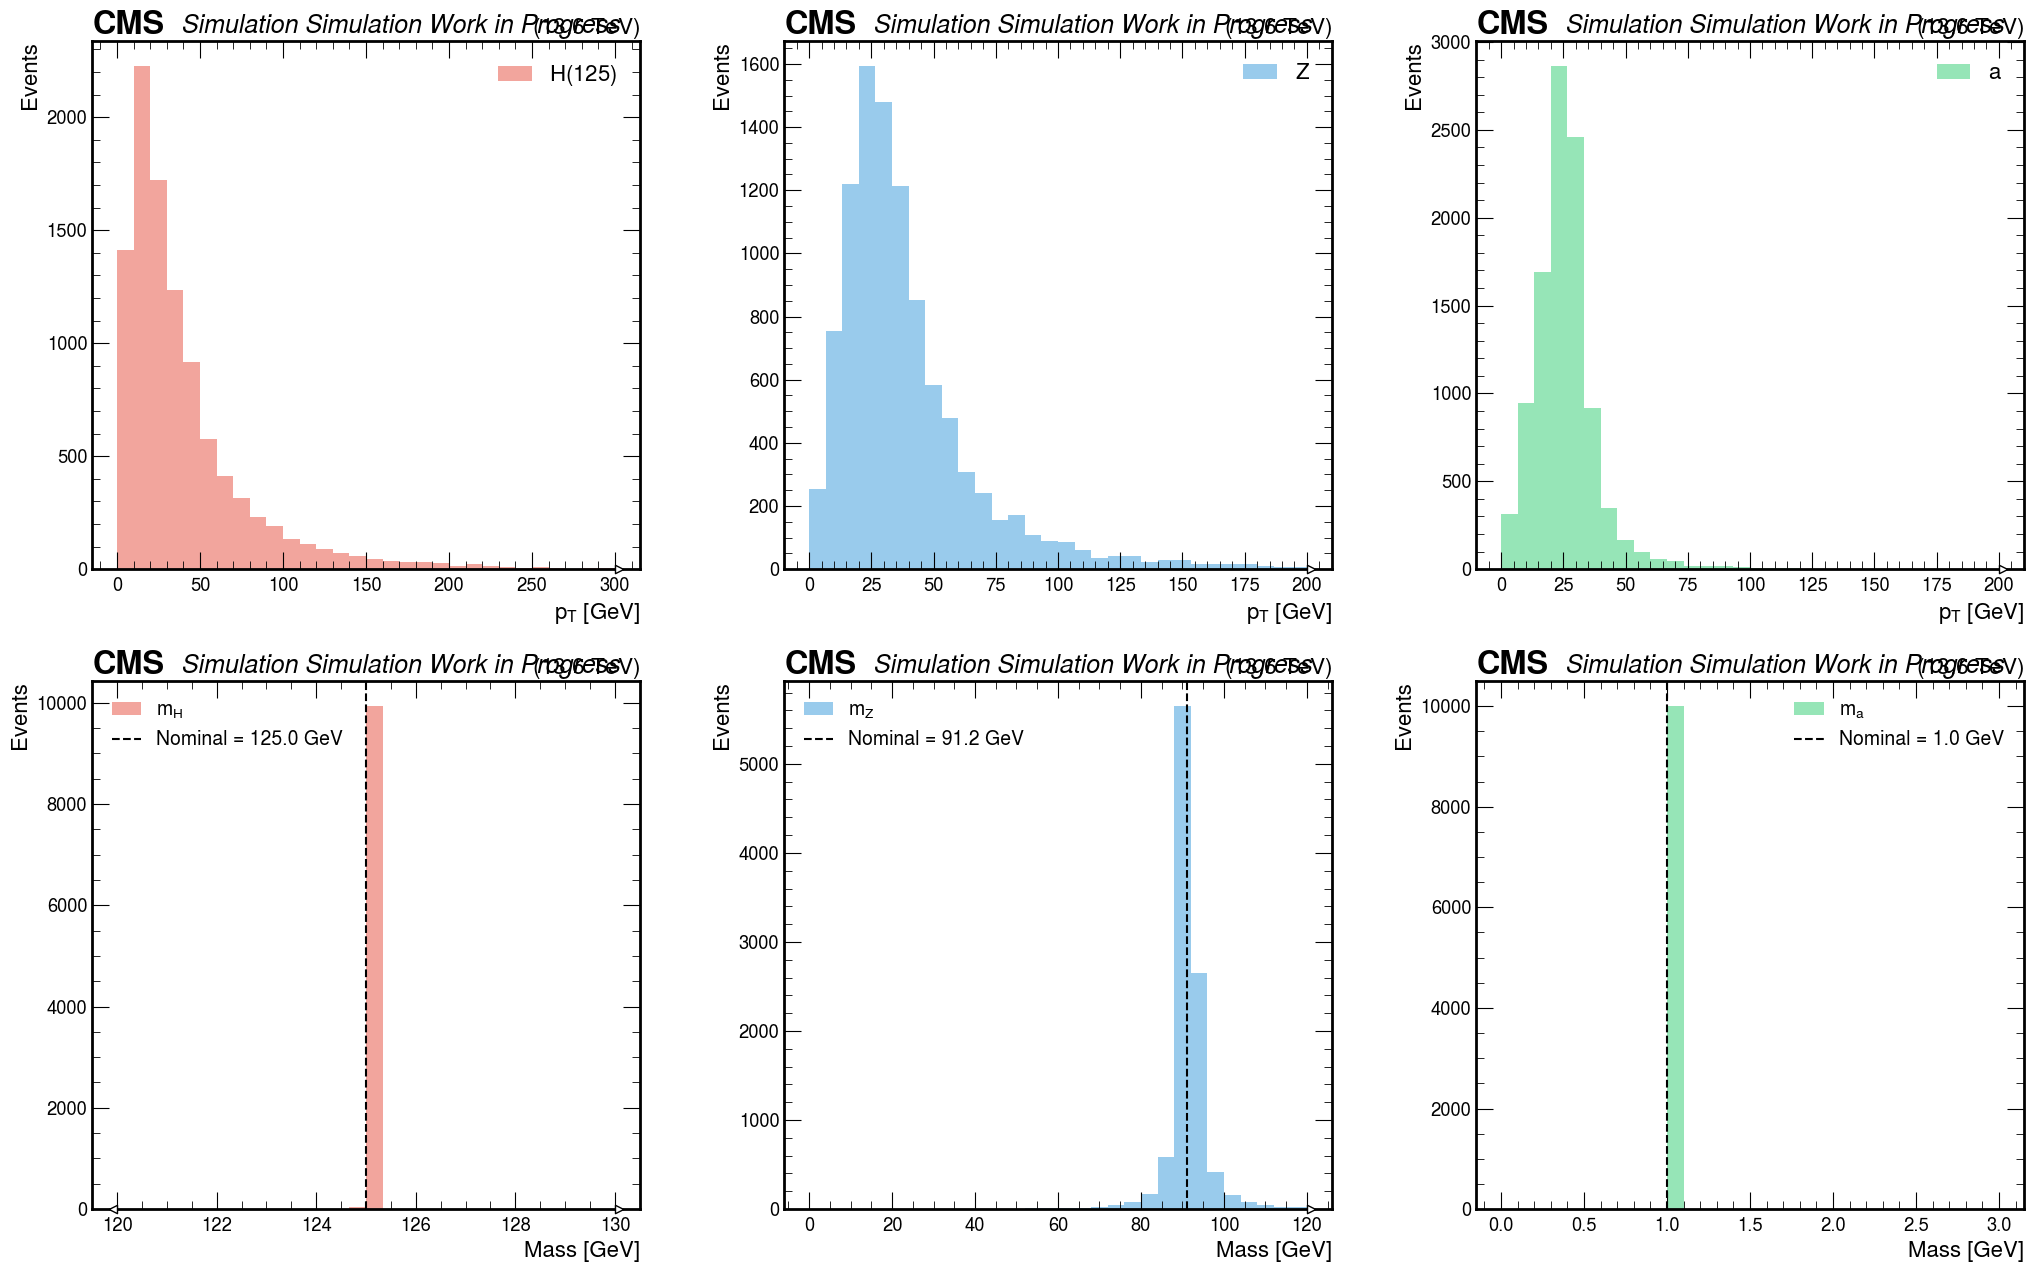

In [21]:
# ── Gen-level plots: Higgs, Z, a ──────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(21, 13))

# Flatten to 1D numpy arrays for histogramming
h_pt  = ak.flatten(gen_higgs.pt).to_numpy()
z_pt  = ak.flatten(gen_Z.pt).to_numpy()
a_pt  = ak.flatten(gen_a.pt).to_numpy()
h_m   = ak.flatten(gen_higgs.mass).to_numpy()
z_m   = ak.flatten(gen_Z.mass).to_numpy()
a_m   = ak.flatten(gen_a.mass).to_numpy()
h_eta = ak.flatten(gen_higgs.eta).to_numpy()
z_eta = ak.flatten(gen_Z.eta).to_numpy()
a_eta = ak.flatten(gen_a.eta).to_numpy()

# Row 1: pT distributions
for ax, data, label, color, xmax in zip(
    axes[0],
    [h_pt, z_pt, a_pt],
    [r"$H(125)$", r"$Z$", r"$a$"],
    ["#e74c3c", "#3498db", "#2ecc71"],
    [300, 200, 200],
):
    h = hist.Hist(hist.axis.Regular(30, 0, xmax, label=r"$p_T$ [GeV]"))
    h.fill(data)
    hep.histplot(h, ax=ax, histtype="fill", alpha=0.5, color=color, edgecolor=color, label=label)
    ax.set_ylabel("Events")
    ax.legend(fontsize=16)
    cms_label(ax)

# Row 2: mass distributions
for ax, data, label, color, xrange, vline in zip(
    axes[1],
    [h_m, z_m, a_m],
    [r"$m_H$", r"$m_Z$", r"$m_a$"],
    ["#e74c3c", "#3498db", "#2ecc71"],
    [(120, 130), (0, 120), (0, 3)],
    [125.0, 91.2, MASS_A],
):
    h = hist.Hist(hist.axis.Regular(30, *xrange, label="Mass [GeV]"))
    h.fill(data)
    hep.histplot(h, ax=ax, histtype="fill", alpha=0.5, color=color, edgecolor=color, label=label)
    ax.axvline(vline, color="black", linestyle="--", linewidth=1.5, label=f"Nominal = {vline} GeV")
    ax.set_ylabel("Events")
    ax.legend(fontsize=14)
    cms_label(ax)

save_and_show(fig, "gen_kinematics.png")

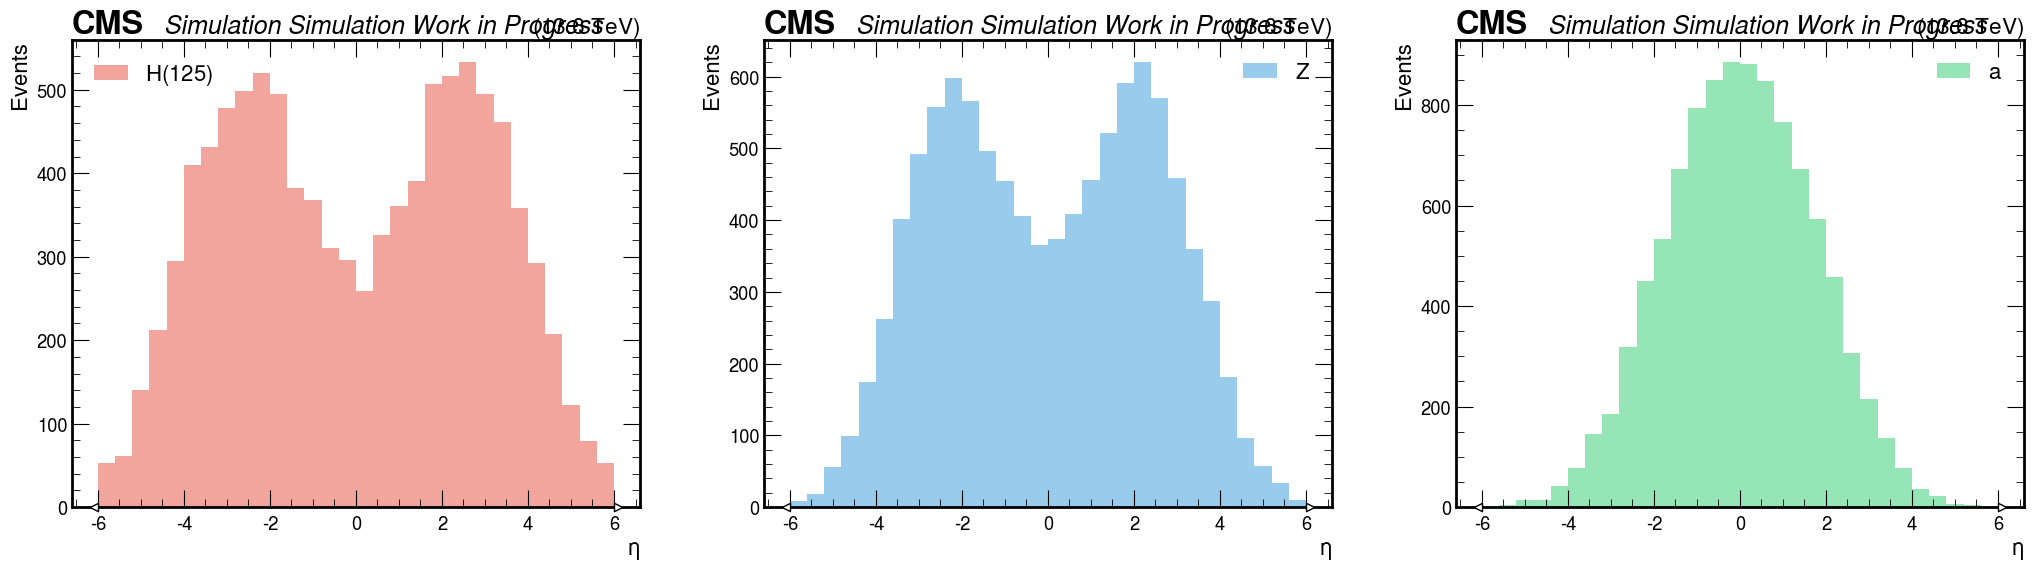

In [22]:
# ── Gen-level angular distributions ───────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for ax, data, label, color in zip(
    axes,
    [h_eta, z_eta, a_eta],
    [r"$H(125)$", r"$Z$", r"$a$"],
    ["#e74c3c", "#3498db", "#2ecc71"],
):
    h = hist.Hist(hist.axis.Regular(30, -6, 6, label=r"$\eta$"))
    h.fill(data)
    hep.histplot(h, ax=ax, histtype="fill", alpha=0.5, color=color, edgecolor=color, label=label)
    ax.set_ylabel("Events")
    ax.legend(fontsize=16)
    cms_label(ax)

save_and_show(fig, "gen_eta.png")

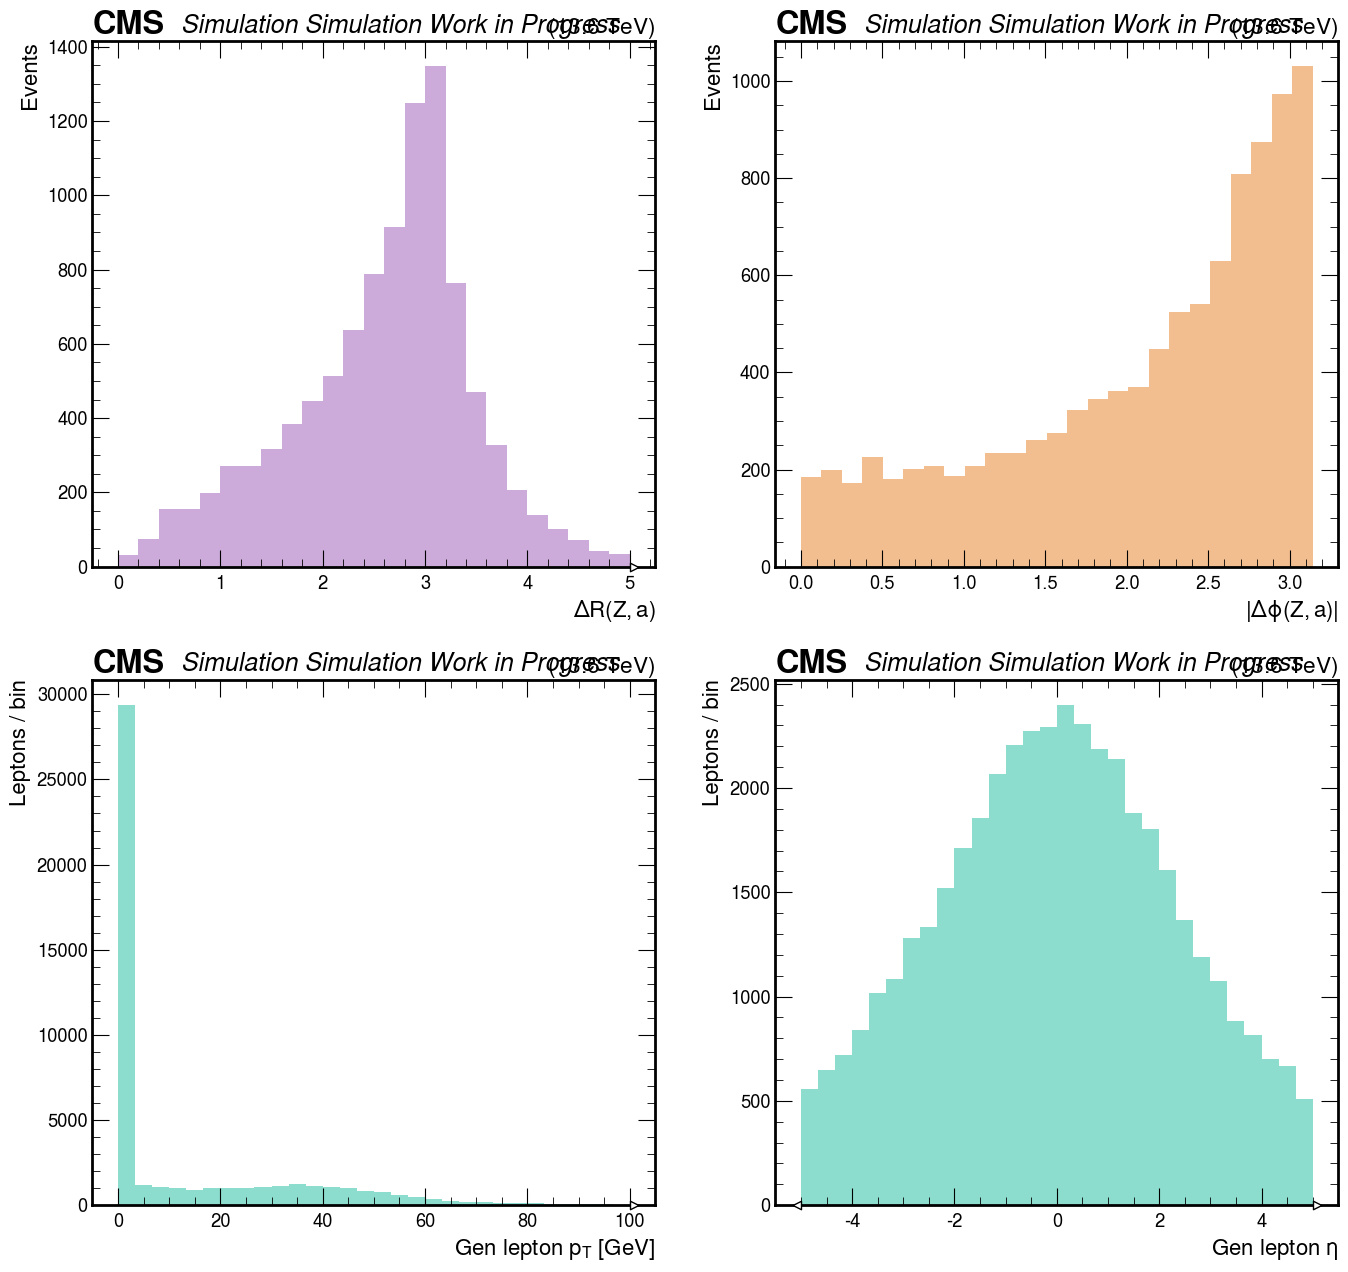

In [23]:
# ── Gen-level ΔR(Z, a) and dilepton mass ─────────────────────────────────────
# Build Lorentz vectors for Z and a (per-event, take first candidate)
gen_Z_vec = vector.zip({
    "pt": gen_Z.pt[:, 0:1], "eta": gen_Z.eta[:, 0:1],
    "phi": gen_Z.phi[:, 0:1], "mass": gen_Z.mass[:, 0:1],
})
gen_a_vec = vector.zip({
    "pt": gen_a.pt[:, 0:1], "eta": gen_a.eta[:, 0:1],
    "phi": gen_a.phi[:, 0:1], "mass": gen_a.mass[:, 0:1],
})

gen_dR_Za = ak.flatten(gen_Z_vec.deltaR(gen_a_vec)).to_numpy()
gen_dphi_Za = ak.flatten(np.abs(gen_Z_vec.deltaphi(gen_a_vec))).to_numpy()

# Gen-level lepton pT and eta (use gen_leptons defined above)
gen_lep_pt  = ak.flatten(gen_leptons.pt).to_numpy()
gen_lep_eta = ak.flatten(gen_leptons.eta).to_numpy()

fig, axes = plt.subplots(2, 2, figsize=(14, 13))

# ΔR(Z, a)
h = hist.Hist(hist.axis.Regular(25, 0, 5, label=r"$\Delta R(Z, a)$"))
h.fill(gen_dR_Za)
hep.histplot(h, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#9b59b6", edgecolor="#9b59b6")
axes[0, 0].set_ylabel("Events")
cms_label(axes[0, 0])

# Δφ(Z, a)
h = hist.Hist(hist.axis.Regular(25, 0, np.pi, label=r"$|\Delta\phi(Z, a)|$"))
h.fill(gen_dphi_Za)
hep.histplot(h, ax=axes[0, 1], histtype="fill", alpha=0.5, color="#e67e22", edgecolor="#e67e22")
axes[0, 1].set_ylabel("Events")
cms_label(axes[0, 1])

# Gen lepton pT
h = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"Gen lepton $p_T$ [GeV]"))
h.fill(gen_lep_pt)
hep.histplot(h, ax=axes[1, 0], histtype="fill", alpha=0.5, color="#1abc9c", edgecolor="#1abc9c")
axes[1, 0].set_ylabel("Leptons / bin")
cms_label(axes[1, 0])

# Gen lepton eta
h = hist.Hist(hist.axis.Regular(30, -5, 5, label=r"Gen lepton $\eta$"))
h.fill(gen_lep_eta)
hep.histplot(h, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#1abc9c", edgecolor="#1abc9c")
axes[1, 1].set_ylabel("Leptons / bin")
cms_label(axes[1, 1])

save_and_show(fig, "gen_deltaR_leptons.png")

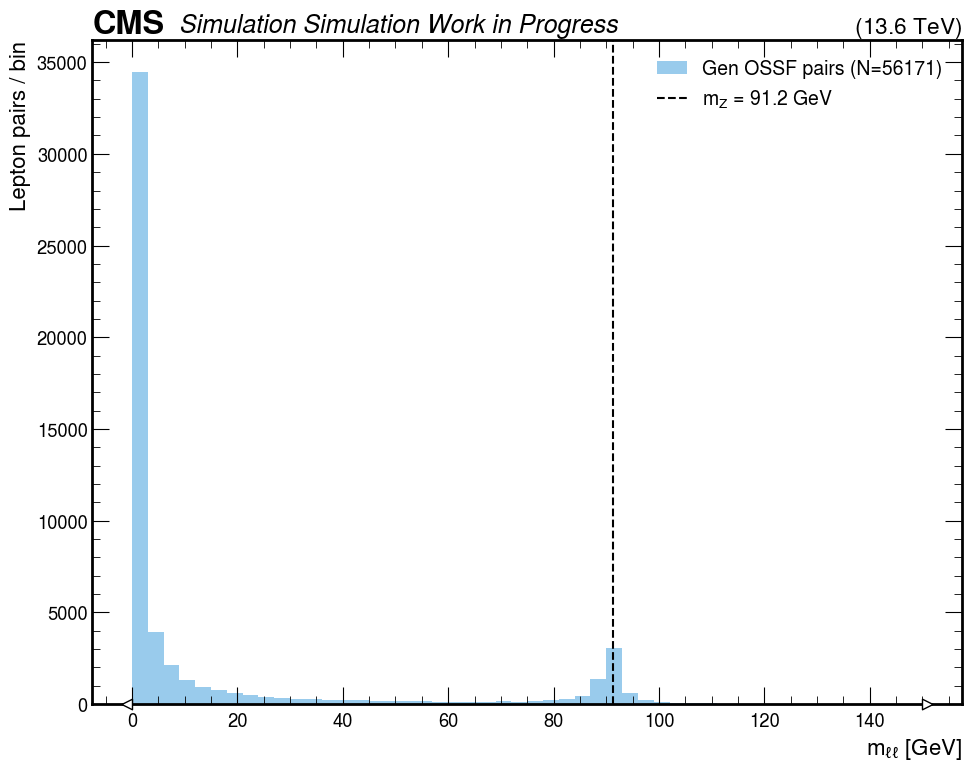

In [24]:
# ── Gen-level dilepton invariant mass (mll) ───────────────────────────────────
# Build Lorentz vectors for gen leptons and compute all OSSF pair masses
gen_lep_vec = vector.zip({
    "pt": gen_leptons.pt, "eta": gen_leptons.eta,
    "phi": gen_leptons.phi, "mass": gen_leptons.mass,
})
gen_lep_pdgId = gen_leptons.pdgId

# All pairs
gen_pairs = ak.argcombinations(gen_lep_vec, 2, axis=1)
gi0, gi1 = ak.unzip(gen_pairs)
gl0 = gen_lep_vec[gi0]
gl1 = gen_lep_vec[gi1]
gq0 = gen_lep_pdgId[gi0]
gq1 = gen_lep_pdgId[gi1]

# Opposite-sign same-flavour
ossf_mask = (gq0 + gq1 == 0)  # e.g. +11 + -11 = 0
gl0_ossf = gl0[ossf_mask]
gl1_ossf = gl1[ossf_mask]
gen_mll = (gl0_ossf + gl1_ossf).mass

gen_mll_flat = ak.flatten(gen_mll).to_numpy()

fig, ax = plt.subplots(figsize=(10, 8))
h = hist.Hist(hist.axis.Regular(50, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h.fill(gen_mll_flat)
hep.histplot(h, ax=ax, histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db",
             label=f"Gen OSSF pairs (N={len(gen_mll_flat)})")
ax.axvline(91.2, color="black", linestyle="--", linewidth=1.5, label=r"$m_Z$ = 91.2 GeV")
ax.set_ylabel("Lepton pairs / bin")
ax.legend(fontsize=14)
cms_label(ax)
save_and_show(fig, "gen_mll.png")

Gen-level a decay modes:
  a → 21, 21: 864 events (86%)
  a → $\mu^+$, $\mu^-$: 135 events (14%)
  a → -1, 1: 1 events (0%)

Gen-level Z decay modes:
  Z → $\mu^+$, $\mu^-$: 345 events (34%)
  Z → $e^+$, $e^-$: 338 events (34%)
  Z → $\tau^+$, $\tau^-$: 317 events (32%)


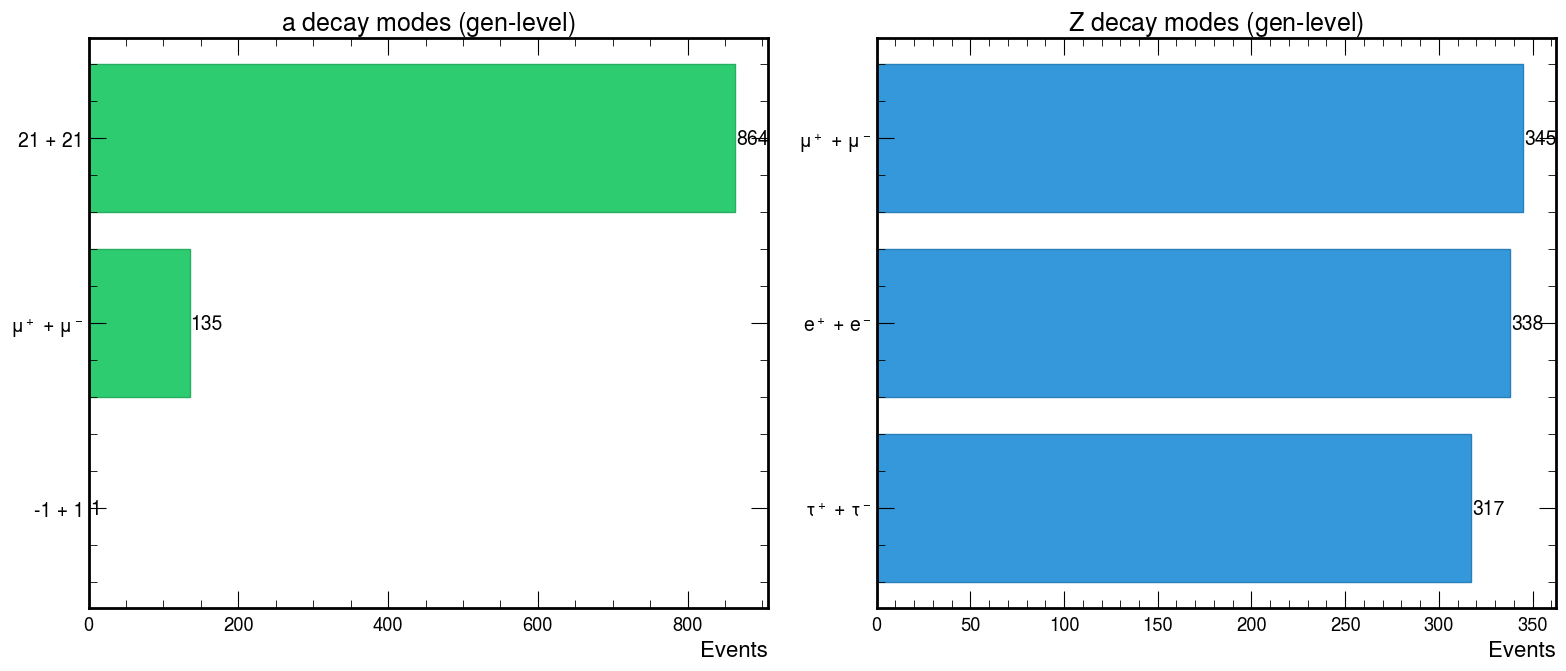

In [25]:
# ── Gen-level a and Z decay products ───────────────────────────────────────────
from collections import Counter

pdg_labels = {
    11: r"$e^-$", -11: r"$e^+$", 13: r"$\mu^-$", -13: r"$\mu^+$",
    15: r"$\tau^-$", -15: r"$\tau^+$", 211: r"$\pi^+$", -211: r"$\pi^-$",
    111: r"$\pi^0$", 22: r"$\gamma$", 321: r"$K^+$", -321: r"$K^-$",
    310: r"$K_S^0$", 130: r"$K_L^0$",
}

def get_decay_modes(events, parent_pdgId, max_events=1_000):
    """Get decay daughter PDG IDs for a given parent particle."""
    modes = Counter()
    daughter_pdgIds = []
    for ievt in range(min(len(events), max_events)):
        pdg = events.GenPart_pdgId[ievt]
        mom = events.GenPart_genPartIdxMother[ievt]
        flags = events.GenPart_statusFlags[ievt]
        for i in range(len(pdg)):
            if abs(pdg[i]) == parent_pdgId and bool(flags[i] & (1 << 13)):
                daughters = tuple(sorted([int(pdg[j]) for j in range(len(pdg)) if mom[j] == i]))
                modes[daughters] += 1
                for d in daughters:
                    daughter_pdgIds.append(abs(d))
    return modes, daughter_pdgIds

a_modes, a_daughter_ids = get_decay_modes(events, 36)
z_modes, z_daughter_ids = get_decay_modes(events, 23)

# Print decay tables
print("Gen-level a decay modes:")
for mode, count in a_modes.most_common():
    names = ", ".join(pdg_labels.get(p, str(p)) for p in mode)
    print(f"  a → {names}: {count} events ({100*count/sum(a_modes.values()):.0f}%)")

print("\nGen-level Z decay modes:")
for mode, count in z_modes.most_common():
    names = ", ".join(pdg_labels.get(p, str(p)) for p in mode)
    print(f"  Z → {names}: {count} events ({100*count/sum(z_modes.values()):.0f}%)")

# ── Plot: a decay daughter PDG IDs ────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# a daughters bar chart by decay mode
a_mode_labels = []
a_mode_counts = []
for mode, count in a_modes.most_common():
    label = " + ".join(pdg_labels.get(p, str(p)) for p in mode)
    a_mode_labels.append(label)
    a_mode_counts.append(count)

axes[0].barh(range(len(a_mode_labels)), a_mode_counts, color="#2ecc71", edgecolor="#27ae60")
axes[0].set_yticks(range(len(a_mode_labels)))
axes[0].set_yticklabels(a_mode_labels, fontsize=14)
axes[0].set_xlabel("Events", fontsize=16)
axes[0].set_title(r"$a$ decay modes (gen-level)", fontsize=18)
axes[0].invert_yaxis()
for i, v in enumerate(a_mode_counts):
    axes[0].text(v + 0.5, i, str(v), va="center", fontsize=14)

# Z daughters bar chart by decay mode
z_mode_labels = []
z_mode_counts = []
for mode, count in z_modes.most_common():
    label = " + ".join(pdg_labels.get(p, str(p)) for p in mode)
    z_mode_labels.append(label)
    z_mode_counts.append(count)

axes[1].barh(range(len(z_mode_labels)), z_mode_counts, color="#3498db", edgecolor="#2980b9")
axes[1].set_yticks(range(len(z_mode_labels)))
axes[1].set_yticklabels(z_mode_labels, fontsize=14)
axes[1].set_xlabel("Events", fontsize=16)
axes[1].set_title(r"$Z$ decay modes (gen-level)", fontsize=18)
axes[1].invert_yaxis()
for i, v in enumerate(z_mode_counts):
    axes[1].text(v + 0.5, i, str(v), va="center", fontsize=14)

save_and_show(fig, "gen_decay_modes.png")

a → μ+μ- events: 1563 / 10000
a → gg    events: 8414 / 10000

Reco m(μ+μ-):  mean = 0.9439 ± 0.0842 GeV
Reco m(gg):    mean = 1.0001 ± 0.0267 GeV  ⚠ parton-level
Gen-level m(a): mean = 1.0000 ± 0.000000 GeV


/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer wei

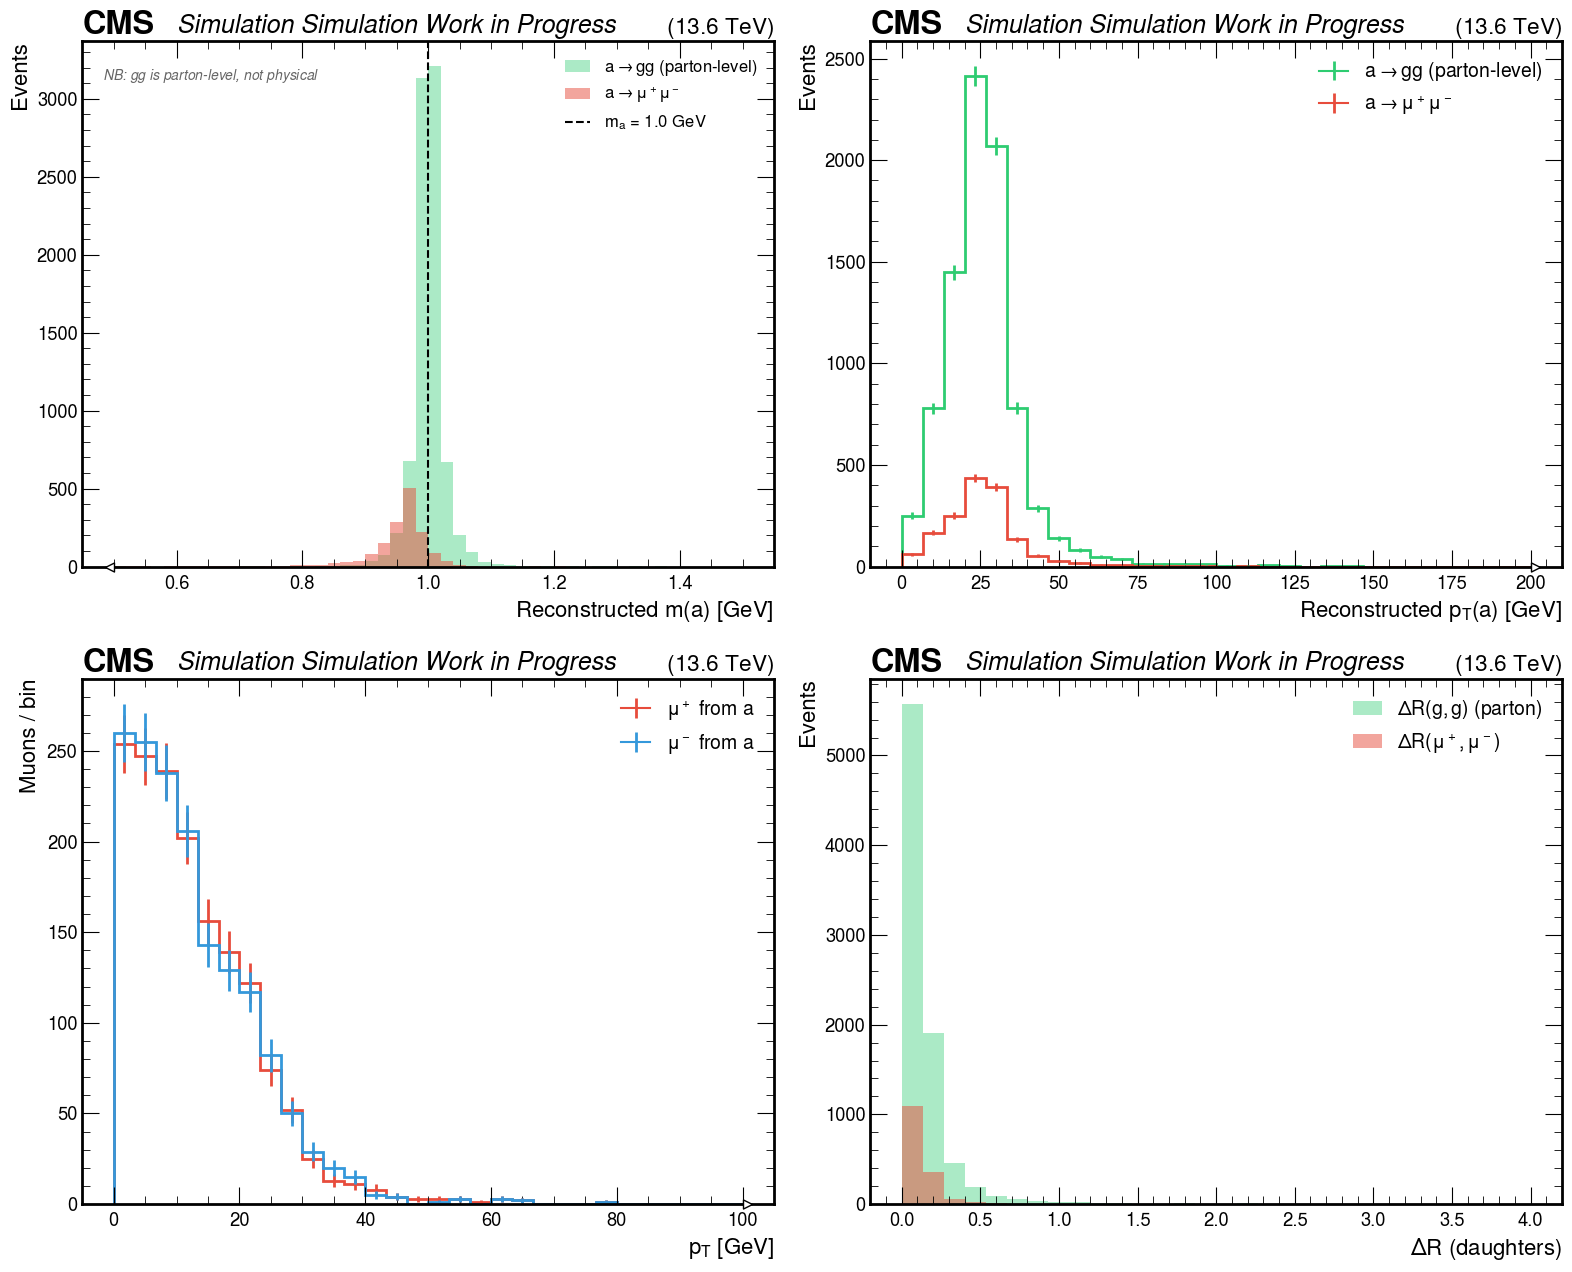

In [26]:
# ── Reconstruct a from GenPart direct daughters ──────────────────────────────
# At mA = 1.0 GeV the dominant decays are a → gg (86%) and a → μ+μ- (14%).
#
# ⚠ CAVEAT: the a → gg channel uses parton-level gluons from the Pythia record.
#   These are NOT physical observables — gluons hadronise before reaching the
#   detector. The m(gg) ≈ mA result is a trivial consequence of 4-momentum
#   conservation at the decay vertex.  For a meaningful hadronic reconstruction,
#   one would need to sum all stable descendants of the a, but NanoAOD's GenPart
#   collection is heavily pruned and does not preserve the full hadronisation
#   chain.  The muonic channel (a → μ+μ-) is the physically meaningful one here.

# Mother PDG ID for each GenPart (motherIdx = -1 → no mother, use 0 as safe index)
has_mother = genpart.motherIdx >= 0
safe_mother_idx = ak.where(has_mother, genpart.motherIdx, 0)
mother_pdgId = genpart.pdgId[safe_mother_idx]
mother_is_a = has_mother & (abs(mother_pdgId) == 36)

# ── Channel 1: a → μ+μ- ──────────────────────────────────────────────────────
is_muon = (abs(genpart.pdgId) == 13)
muons_from_a = genpart[is_muon & mother_is_a]
mu_plus  = muons_from_a[muons_from_a.pdgId == -13]
mu_minus = muons_from_a[muons_from_a.pdgId ==  13]

mu_plus_vec = vector.zip({
    "pt": mu_plus.pt, "eta": mu_plus.eta,
    "phi": mu_plus.phi, "mass": mu_plus.mass,
})
mu_minus_vec = vector.zip({
    "pt": mu_minus.pt, "eta": mu_minus.eta,
    "phi": mu_minus.phi, "mass": mu_minus.mass,
})

has_mu_pair = (ak.num(mu_plus) >= 1) & (ak.num(mu_minus) >= 1)
reco_a_mumu = mu_plus_vec[has_mu_pair][:, 0:1] + mu_minus_vec[has_mu_pair][:, 0:1]
reco_a_mumu_mass = ak.flatten(reco_a_mumu.mass).to_numpy()
reco_a_mumu_pt   = ak.flatten(reco_a_mumu.pt).to_numpy()

# ── Channel 2: a → gg (parton-level — see caveat above) ──────────────────────
is_gluon = (abs(genpart.pdgId) == 21)
gluons_from_a = genpart[is_gluon & mother_is_a]

gluon_vec = vector.zip({
    "pt": gluons_from_a.pt, "eta": gluons_from_a.eta,
    "phi": gluons_from_a.phi, "mass": gluons_from_a.mass,
})

has_gg_pair = (ak.num(gluons_from_a) >= 2)
reco_a_gg = gluon_vec[has_gg_pair][:, 0:1] + gluon_vec[has_gg_pair][:, 1:2]
reco_a_gg_mass = ak.flatten(reco_a_gg.mass).to_numpy()
reco_a_gg_pt   = ak.flatten(reco_a_gg.pt).to_numpy()

# Gen-level a mass for comparison
gen_a_mass_np = ak.flatten(gen_a.mass).to_numpy()

print(f"a → μ+μ- events: {ak.sum(has_mu_pair)} / {len(events)}")
print(f"a → gg    events: {ak.sum(has_gg_pair)} / {len(events)}")
print(f"\nReco m(μ+μ-):  mean = {np.mean(reco_a_mumu_mass):.4f} ± {np.std(reco_a_mumu_mass):.4f} GeV")
print(f"Reco m(gg):    mean = {np.mean(reco_a_gg_mass):.4f} ± {np.std(reco_a_gg_mass):.4f} GeV  ⚠ parton-level")
print(f"Gen-level m(a): mean = {np.mean(gen_a_mass_np):.4f} ± {np.std(gen_a_mass_np):.6f} GeV")

# ── Plot ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 13))

# (0,0) Reconstructed a mass – both channels
mass_lo, mass_hi = max(0, MASS_A - 0.5), MASS_A + 0.5
h_mm = hist.Hist(hist.axis.Regular(50, mass_lo, mass_hi, label=r"Reconstructed $m(a)$ [GeV]"))
h_gg = hist.Hist(hist.axis.Regular(50, mass_lo, mass_hi, label=r"Reconstructed $m(a)$ [GeV]"))
h_mm.fill(reco_a_mumu_mass)
h_gg.fill(reco_a_gg_mass)
hep.histplot(h_gg, ax=axes[0, 0], histtype="fill", alpha=0.4, color="#2ecc71", edgecolor="#27ae60",
             label=r"$a \to gg$ (parton-level)")
hep.histplot(h_mm, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#c0392b",
             label=r"$a \to \mu^+\mu^-$")
axes[0, 0].axvline(MASS_A, color="black", linestyle="--", linewidth=1.5, label=f"$m_a$ = {MASS_A} GeV")
axes[0, 0].set_ylabel("Events")
axes[0, 0].legend(fontsize=12)
axes[0, 0].text(0.03, 0.95, r"NB: $gg$ is parton-level, not physical",
                transform=axes[0, 0].transAxes, fontsize=10, va="top",
                color="#666666", style="italic")
cms_label(axes[0, 0])

# (0,1) Reconstructed a pT – both channels
h_pt_mm = hist.Hist(hist.axis.Regular(30, 0, 200, label=r"Reconstructed $p_T(a)$ [GeV]"))
h_pt_gg = hist.Hist(hist.axis.Regular(30, 0, 200, label=r"Reconstructed $p_T(a)$ [GeV]"))
h_pt_mm.fill(reco_a_mumu_pt)
h_pt_gg.fill(reco_a_gg_pt)
hep.histplot(h_pt_gg, ax=axes[0, 1], histtype="step", color="#2ecc71", linewidth=2,
             label=r"$a \to gg$ (parton-level)")
hep.histplot(h_pt_mm, ax=axes[0, 1], histtype="step", color="#e74c3c", linewidth=2,
             label=r"$a \to \mu^+\mu^-$")
axes[0, 1].set_ylabel("Events")
axes[0, 1].legend(fontsize=14)
cms_label(axes[0, 1])

# (1,0) Daughter pT spectra (muons from a)
mu_plus_pt  = ak.flatten(mu_plus.pt).to_numpy()
mu_minus_pt = ak.flatten(mu_minus.pt).to_numpy()
h_mup = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"$p_T$ [GeV]"))
h_mum = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"$p_T$ [GeV]"))
h_mup.fill(mu_plus_pt)
h_mum.fill(mu_minus_pt)
hep.histplot(h_mup, ax=axes[1, 0], histtype="step", color="#e74c3c", linewidth=2, label=r"$\mu^+$ from $a$")
hep.histplot(h_mum, ax=axes[1, 0], histtype="step", color="#3498db", linewidth=2, label=r"$\mu^-$ from $a$")
axes[1, 0].set_ylabel("Muons / bin")
axes[1, 0].legend(fontsize=14)
cms_label(axes[1, 0])

# (1,1) ΔR between daughters
# μ+μ- channel
mu_p_1 = mu_plus_vec[has_mu_pair][:, 0:1]
mu_m_1 = mu_minus_vec[has_mu_pair][:, 0:1]
dR_mumu = ak.flatten(mu_p_1.deltaR(mu_m_1)).to_numpy()
# gg channel
g1 = gluon_vec[has_gg_pair][:, 0:1]
g2 = gluon_vec[has_gg_pair][:, 1:2]
dR_gg = ak.flatten(g1.deltaR(g2)).to_numpy()

h_dr_mm = hist.Hist(hist.axis.Regular(30, 0, 4, label=r"$\Delta R$ (daughters)"))
h_dr_gg = hist.Hist(hist.axis.Regular(30, 0, 4, label=r"$\Delta R$ (daughters)"))
h_dr_mm.fill(dR_mumu)
h_dr_gg.fill(dR_gg)
hep.histplot(h_dr_gg, ax=axes[1, 1], histtype="fill", alpha=0.4, color="#2ecc71", edgecolor="#27ae60",
             label=r"$\Delta R(g, g)$ (parton)")
hep.histplot(h_dr_mm, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#c0392b",
             label=r"$\Delta R(\mu^+, \mu^-)$")
axes[1, 1].set_ylabel("Events")
axes[1, 1].legend(fontsize=14)
cms_label(axes[1, 1])

save_and_show(fig, "gen_a_daughter_reconstruction.png")

## Reconstructed Object Selection

Apply baseline selection cuts for muons, electrons, and jets following standard CMS Run 3 recommendations.

In [27]:
# ── Muon selection ─────────────────────────────────────────────────────────────
mu_pt_cut  = events.Muon_pt > 5.0          # pT > 5 GeV
mu_eta_cut = np.abs(events.Muon_eta) < 2.4  # |η| < 2.4
mu_id_cut  = events.Muon_mediumId           # Medium ID
mu_iso_cut = events.Muon_pfRelIso04_all < 0.15  # tight isolation

mu_sel = mu_pt_cut & mu_eta_cut & mu_id_cut & mu_iso_cut

# Build muon 4-vectors
sel_mu = vector.zip({
    "pt":   events.Muon_pt[mu_sel],
    "eta":  events.Muon_eta[mu_sel],
    "phi":  events.Muon_phi[mu_sel],
    "mass": events.Muon_mass[mu_sel],
})
sel_mu_charge = events.Muon_charge[mu_sel]

# ── Electron selection ────────────────────────────────────────────────────────
el_pt_cut  = events.Electron_pt > 10.0           # pT > 10 GeV
el_eta_cut = np.abs(events.Electron_eta) < 2.5  # |η| < 2.5
el_id_cut  = events.Electron_cutBased >= 3       # Medium cut-based ID and isolation

el_sel = el_pt_cut & el_eta_cut & el_id_cut

sel_el = vector.zip({
    "pt":   events.Electron_pt[el_sel],
    "eta":  events.Electron_eta[el_sel],
    "phi":  events.Electron_phi[el_sel],
    "mass": events.Electron_mass[el_sel],
})
sel_el_charge = events.Electron_charge[el_sel]

# ── Jet selection ─────────────────────────────────────────────────────────────
jet_pt_cut  = events.Jet_pt > 25.0           # pT > 25 GeV
jet_eta_cut = np.abs(events.Jet_eta) < 2.5   # |η| < 2.5

jet_sel = jet_pt_cut & jet_eta_cut

sel_jets = vector.zip({
    "pt":   events.Jet_pt[jet_sel],
    "eta":  events.Jet_eta[jet_sel],
    "phi":  events.Jet_phi[jet_sel],
    "mass": events.Jet_mass[jet_sel],
})
sel_jet_btag = events.Jet_btagDeepFlavB[jet_sel]

# Summary
n_mu  = ak.num(sel_mu)
n_el  = ak.num(sel_el)
n_jet = ak.num(sel_jets)

print(f"Selected muons:     mean {ak.mean(n_mu):.2f}/event,  total {ak.sum(n_mu)}")
print(f"Selected electrons: mean {ak.mean(n_el):.2f}/event,  total {ak.sum(n_el)}")
print(f"Selected jets:      mean {ak.mean(n_jet):.2f}/event, total {ak.sum(n_jet)}")

Selected muons:     mean 0.71/event,  total 7094
Selected electrons: mean 0.49/event,  total 4922
Selected jets:      mean 2.39/event, total 23945


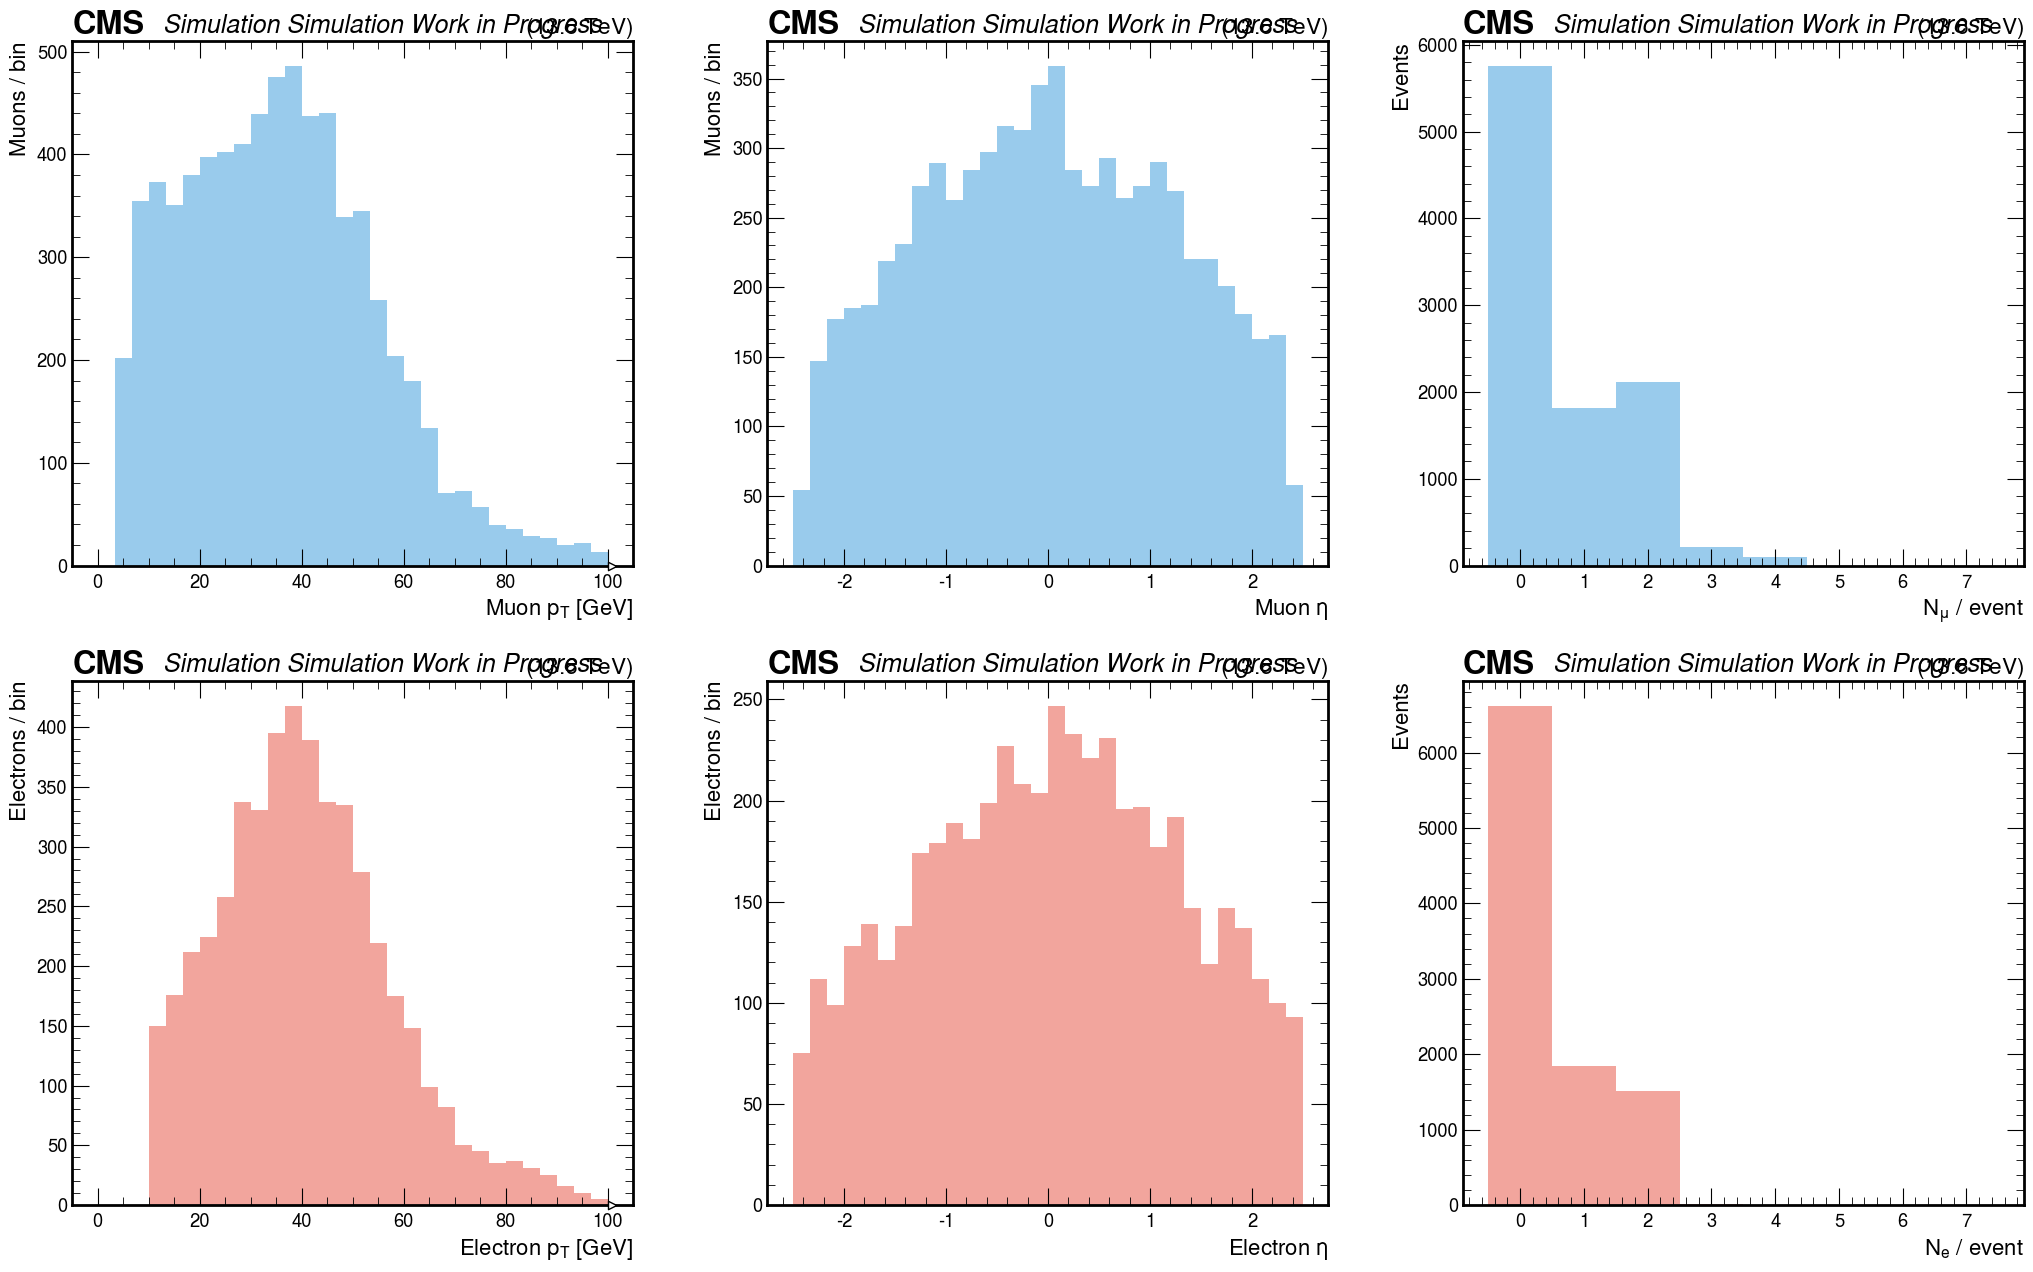

In [28]:
# ── Reco lepton kinematic plots ────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(21, 13))

# Muon pT
all_mu_pt = ak.flatten(sel_mu.pt).to_numpy()
h = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"Muon $p_T$ [GeV]"))
h.fill(all_mu_pt)
hep.histplot(h, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db")
axes[0, 0].set_ylabel("Muons / bin")
cms_label(axes[0, 0])

# Muon eta
all_mu_eta = ak.flatten(sel_mu.eta).to_numpy()
h = hist.Hist(hist.axis.Regular(30, -2.5, 2.5, label=r"Muon $\eta$"))
h.fill(all_mu_eta)
hep.histplot(h, ax=axes[0, 1], histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db")
axes[0, 1].set_ylabel("Muons / bin")
cms_label(axes[0, 1])

# Muon multiplicity
h = hist.Hist(hist.axis.Regular(8, -0.5, 7.5, label=r"$N_{\mu}$ / event"))
h.fill(ak.to_numpy(n_mu))
hep.histplot(h, ax=axes[0, 2], histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db")
axes[0, 2].set_ylabel("Events")
cms_label(axes[0, 2])

# Electron pT
all_el_pt = ak.flatten(sel_el.pt).to_numpy()
h = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"Electron $p_T$ [GeV]"))
h.fill(all_el_pt)
hep.histplot(h, ax=axes[1, 0], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1, 0].set_ylabel("Electrons / bin")
cms_label(axes[1, 0])

# Electron eta
all_el_eta = ak.flatten(sel_el.eta).to_numpy()
h = hist.Hist(hist.axis.Regular(30, -2.5, 2.5, label=r"Electron $\eta$"))
h.fill(all_el_eta)
hep.histplot(h, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1, 1].set_ylabel("Electrons / bin")
cms_label(axes[1, 1])

# Electron multiplicity
h = hist.Hist(hist.axis.Regular(8, -0.5, 7.5, label=r"$N_{e}$ / event"))
h.fill(ak.to_numpy(n_el))
hep.histplot(h, ax=axes[1, 2], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1, 2].set_ylabel("Events")
cms_label(axes[1, 2])

save_and_show(fig, "reco_lepton_kinematics.png")

## Z Boson Reconstruction

Reconstruct Z → ℓ⁺ℓ⁻ candidates from opposite-sign same-flavour (OSSF) lepton pairs. For events with multiple candidates, select the pair whose invariant mass is closest to $m_Z = 91.2$ GeV.

In [29]:
# ── Z → μ⁺μ⁻ reconstruction ───────────────────────────────────────────────────
def reconstruct_z(leptons, charges, mz=91.2):
    """
    Reconstruct Z → ℓℓ from OSSF pairs, selecting the pair closest to mZ.
    Returns per-event Z candidate 4-vector (None-padded for events without a candidate).
    """
    # Build all pairs of indices
    n_lep = ak.num(leptons)
    idx = ak.local_index(leptons)
    pairs = ak.argcombinations(leptons, 2, axis=1)
    i0, i1 = ak.unzip(pairs)

    lep0 = leptons[i0]
    lep1 = leptons[i1]
    q0   = charges[i0]
    q1   = charges[i1]

    # Opposite-sign requirement
    os_mask = (q0 * q1 < 0)
    lep0 = lep0[os_mask]
    lep1 = lep1[os_mask]

    # Compute dilepton invariant mass
    z_cand = lep0 + lep1
    z_mass = z_cand.mass

    # Select pair closest to mZ
    dm = np.abs(z_mass - mz)
    best_idx = ak.argmin(dm, axis=1, keepdims=True)

    z_best = z_cand[best_idx]
    return z_best

# Reconstruct Z from muons
z_from_mu = reconstruct_z(sel_mu, sel_mu_charge)

# Reconstruct Z from electrons
z_from_el = reconstruct_z(sel_el, sel_el_charge)

# Combine: prefer the channel with mass closer to mZ
# Flatten to compare (pad with None for events without candidate)
z_mu_mass = ak.fill_none(ak.firsts(z_from_mu.mass), -999.0)
z_el_mass = ak.fill_none(ak.firsts(z_from_el.mass), -999.0)

prefer_mu = np.abs(z_mu_mass - 91.2) <= np.abs(z_el_mass - 91.2)
# If neither channel has a candidate, skip
has_z_mu = z_mu_mass > 0
has_z_el = z_el_mass > 0
has_z    = has_z_mu | has_z_el

# Build final Z candidate arrays
z_pt   = ak.where(prefer_mu, ak.fill_none(ak.firsts(z_from_mu.pt), 0.0),   ak.fill_none(ak.firsts(z_from_el.pt), 0.0))
z_eta  = ak.where(prefer_mu, ak.fill_none(ak.firsts(z_from_mu.eta), 0.0),  ak.fill_none(ak.firsts(z_from_el.eta), 0.0))
z_phi  = ak.where(prefer_mu, ak.fill_none(ak.firsts(z_from_mu.phi), 0.0),  ak.fill_none(ak.firsts(z_from_el.phi), 0.0))
z_mass = ak.where(prefer_mu, z_mu_mass, z_el_mass)
z_channel = ak.where(prefer_mu & has_z_mu, 1, ak.where(has_z_el, 2, 0))  # 1=μμ, 2=ee, 0=none

n_z = ak.sum(has_z)
n_z_mm = ak.sum(z_channel == 1)
n_z_ee = ak.sum(z_channel == 2)
print(f"Z candidates found: {n_z} total ({n_z_mm} μμ, {n_z_ee} ee)")
print(f"Events without Z:   {ak.sum(~has_z)}")

Z candidates found: 3818 total (2310 μμ, 1508 ee)
Events without Z:   6182


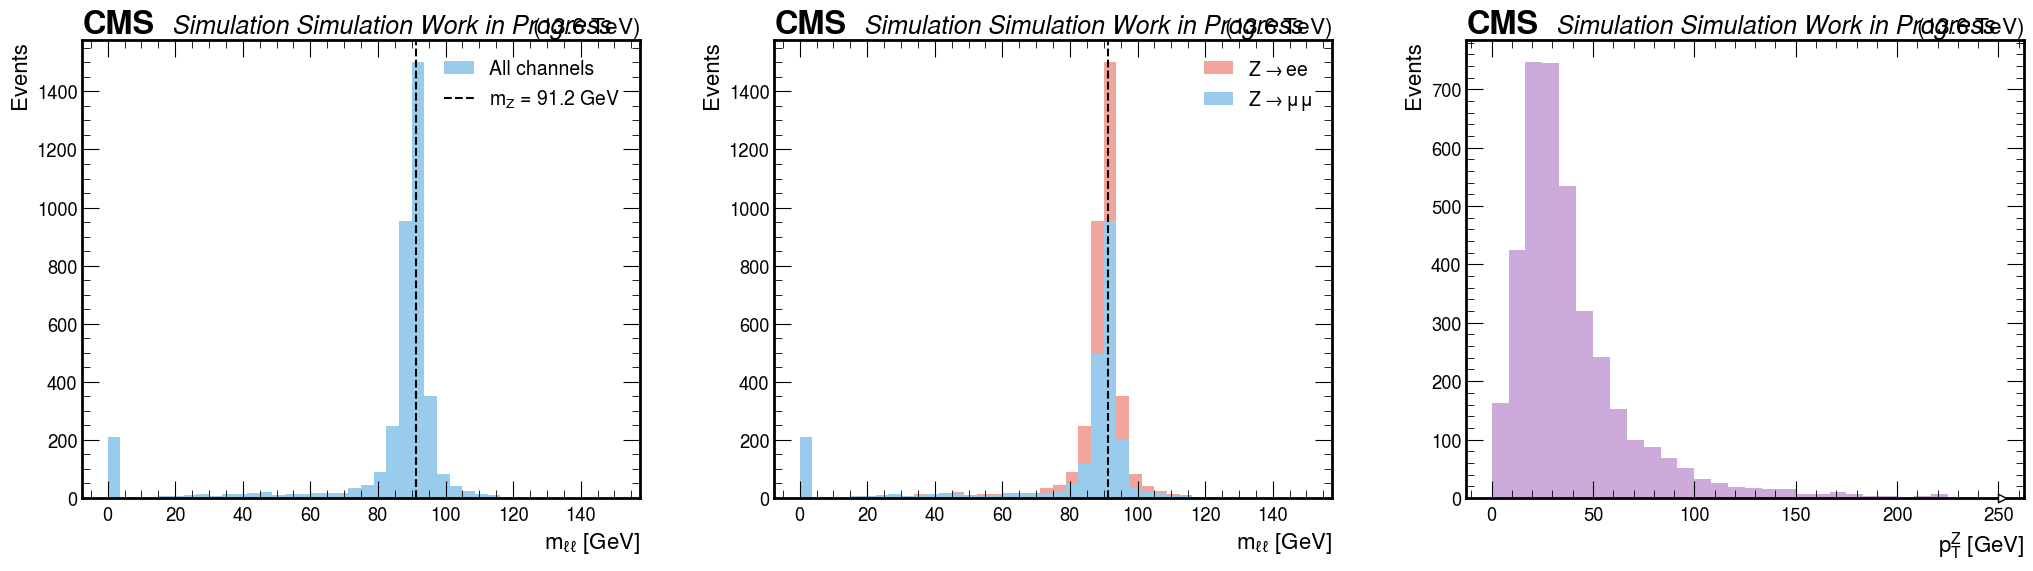

In [30]:
# ── Z candidate plots ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Z mass (all channels)
z_mass_arr = ak.to_numpy(z_mass[has_z])
h = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h.fill(z_mass_arr)
hep.histplot(h, ax=axes[0], histtype="fill", alpha=0.5, color="#3498db", edgecolor="#3498db",
             label="All channels")
axes[0].axvline(91.2, color="black", linestyle="--", linewidth=1.5, label=r"$m_Z$ = 91.2 GeV")
axes[0].set_ylabel("Events")
axes[0].legend(fontsize=14)
cms_label(axes[0])

# Z mass by channel
z_mass_mm = ak.to_numpy(z_mass[z_channel == 1])
z_mass_ee = ak.to_numpy(z_mass[z_channel == 2])
h_mm = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_ee = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_mm.fill(z_mass_mm)
h_ee.fill(z_mass_ee)
hep.histplot([h_mm, h_ee], ax=axes[1], histtype="fill", alpha=0.5,
             label=[r"$Z \to \mu\mu$", r"$Z \to ee$"],
             color=["#3498db", "#e74c3c"], edgecolor=["#3498db", "#e74c3c"], stack=True)
axes[1].axvline(91.2, color="black", linestyle="--", linewidth=1.5)
axes[1].set_ylabel("Events")
axes[1].legend(fontsize=14)
cms_label(axes[1])

# Z pT
z_pt_arr = ak.to_numpy(z_pt[has_z])
h = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h.fill(z_pt_arr)
hep.histplot(h, ax=axes[2], histtype="fill", alpha=0.5, color="#9b59b6", edgecolor="#9b59b6")
axes[2].set_ylabel("Events")
cms_label(axes[2])

save_and_show(fig, "reco_z_candidate.png")

## Pseudoscalar $a$ Decay and Reconstruction

First we inspect the gen-level $a$ decay products, then attempt to reconstruct $a$ candidates from the `IsoTrack` collection in NanoAOD.

**Reconstruction strategy (IsoTracks):**
1. Select high-purity isolated tracks not overlapping with the Z lepton candidates ($\Delta R > 0.3$)
2. Assign pion mass to each track and combine all opposite-sign pairs
3. Select the pair closest to $m_a$ as the $a$ candidate
4. Combine with the Z candidate to reconstruct $H \to Za$

In [31]:
# ── Reconstruct a → tracks using IsoTracks ─────────────────────────────────────
# Build IsoTrack 4-vectors with pion mass hypothesis
M_PION = 0.13957  # GeV

# IsoTrack quality selection
trk_pt   = events["IsoTrack_pt"]
trk_eta  = events["IsoTrack_eta"]
trk_phi  = events["IsoTrack_phi"]
trk_q    = events["IsoTrack_charge"]
trk_iso  = events["IsoTrack_pfRelIso03_all"]
trk_pv   = events["IsoTrack_fromPV"]
trk_hp   = events["IsoTrack_isHighPurityTrack"]
trk_dxy  = events["IsoTrack_dxy"]
trk_dz   = events["IsoTrack_dz"]
trk_pdgId = events["IsoTrack_pdgId"]

trk_sel = (
    (trk_pt > 0.5)
    & (np.abs(trk_eta) < 2.5)
    & (trk_pv >= 1) # fromPV = 1 loose, 2 tight
    # & (trk_hp == 1) # high purity track selection
    & (np.abs(trk_dxy) < 0.1)
    & (np.abs(trk_dz) < 0.5)
)

# Build 4-vectors for selected tracks
sel_trk_pt  = trk_pt[trk_sel]
sel_trk_eta = trk_eta[trk_sel]
sel_trk_phi = trk_phi[trk_sel]
sel_trk_q   = trk_q[trk_sel]
sel_trk_pdgId = trk_pdgId[trk_sel]

sel_tracks = vector.zip({
    "pt":   sel_trk_pt,
    "eta":  sel_trk_eta,
    "phi":  sel_trk_phi,
    "mass": M_PION * ak.ones_like(sel_trk_pt),
})

n_trk = ak.num(sel_tracks)
print(f"IsoTrack selection: {int(ak.sum(n_trk))} tracks pass quality cuts")
print(f"Events with ≥2 tracks: {int(ak.sum(n_trk >= 2))}")
print(f"Events with ≥1 track:  {int(ak.sum(n_trk >= 1))}")
print(f"Events with 0 tracks:  {int(ak.sum(n_trk == 0))}")

# Lepton overlap removal: remove tracks within ΔR < 0.3 of selected muons or electrons
# Build lepton list for overlap removal
def remove_overlap(tracks, leptons, dr_cut=0.3):
    """Remove tracks overlapping with any lepton within dr_cut."""
    if ak.sum(ak.num(leptons)) == 0:
        return ak.ones_like(tracks.pt, dtype=bool)
    # Cross-product: for each track, check distance to all leptons
    trk_eta_bc, lep_eta_bc = ak.unzip(ak.cartesian([tracks.eta, leptons.eta], axis=1, nested=True))
    trk_phi_bc, lep_phi_bc = ak.unzip(ak.cartesian([tracks.phi, leptons.phi], axis=1, nested=True))
    deta = trk_eta_bc - lep_eta_bc
    dphi = np.mod(trk_phi_bc - lep_phi_bc + np.pi, 2 * np.pi) - np.pi
    dr = np.sqrt(deta**2 + dphi**2)
    min_dr = ak.min(dr, axis=-1)
    return min_dr > dr_cut

not_mu_overlap = remove_overlap(sel_tracks, sel_mu)
not_el_overlap = remove_overlap(sel_tracks, sel_el)
no_overlap = not_mu_overlap & not_el_overlap

clean_tracks = sel_tracks[no_overlap]
clean_q = sel_trk_q[no_overlap]
clean_pdgId = sel_trk_pdgId[no_overlap]
n_clean_trk = ak.num(clean_tracks)

print(f"\nAfter lepton overlap removal:")
print(f"  Tracks remaining: {int(ak.sum(n_clean_trk))}")
print(f"  Events with ≥2 tracks: {int(ak.sum(n_clean_trk >= 2))}")

# Form opposite-sign track pairs → a candidates
pairs = ak.argcombinations(clean_tracks, 2, axis=1)
if ak.sum(ak.num(pairs)) > 0:
    i0, i1 = ak.unzip(pairs)
    t0 = clean_tracks[i0]
    t1 = clean_tracks[i1]
    q0 = clean_q[i0]
    q1 = clean_q[i1]

    os_mask = (q0 * q1 < 0)
    t0_os = t0[os_mask]
    t1_os = t1[os_mask]
    trk_pair_sum = t0_os + t1_os
    trk_pair_mass = trk_pair_sum.mass

    # Best a candidate: OS pair closest to MASS_A
    dm_a = np.abs(trk_pair_mass - MASS_A)
    best_idx = ak.argmin(dm_a, axis=1, keepdims=True)
    a_best = trk_pair_sum[best_idx]

    has_a_cand = (ak.num(trk_pair_mass) > 0)
    a_cand_mass = ak.fill_none(ak.firsts(a_best.mass), -999)
    a_cand_pt   = ak.fill_none(ak.firsts(a_best.pt), -999)
    a_cand_eta  = ak.fill_none(ak.firsts(a_best.eta), -999)
    a_cand_phi  = ak.fill_none(ak.firsts(a_best.phi), -999)
else:
    has_a_cand = ak.zeros_like(n_trk, dtype=bool)
    a_cand_mass = -999 * ak.ones_like(n_trk, dtype=float)
    a_cand_pt   = -999 * ak.ones_like(n_trk, dtype=float)
    a_cand_eta  = -999 * ak.ones_like(n_trk, dtype=float)
    a_cand_phi  = -999 * ak.ones_like(n_trk, dtype=float)
    trk_pair_mass = ak.Array([[] for _ in range(len(events))])

has_a_reco = has_a_cand & (a_cand_mass > 0)
print(f"\na candidates from OS track pairs: {int(ak.sum(has_a_reco))}")
print(f"Events without a candidate: {int(ak.sum(~has_a_reco))}")
print(f"\nNote: IsoTrack collection is sparse — low reconstruction efficiency is expected.")

IsoTrack selection: 3240 tracks pass quality cuts
Events with ≥2 tracks: 400
Events with ≥1 track:  2812
Events with 0 tracks:  7188

After lepton overlap removal:
  Tracks remaining: 3215
  Events with ≥2 tracks: 400

a candidates from OS track pairs: 2
Events without a candidate: 9998

Note: IsoTrack collection is sparse — low reconstruction efficiency is expected.


/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer wei

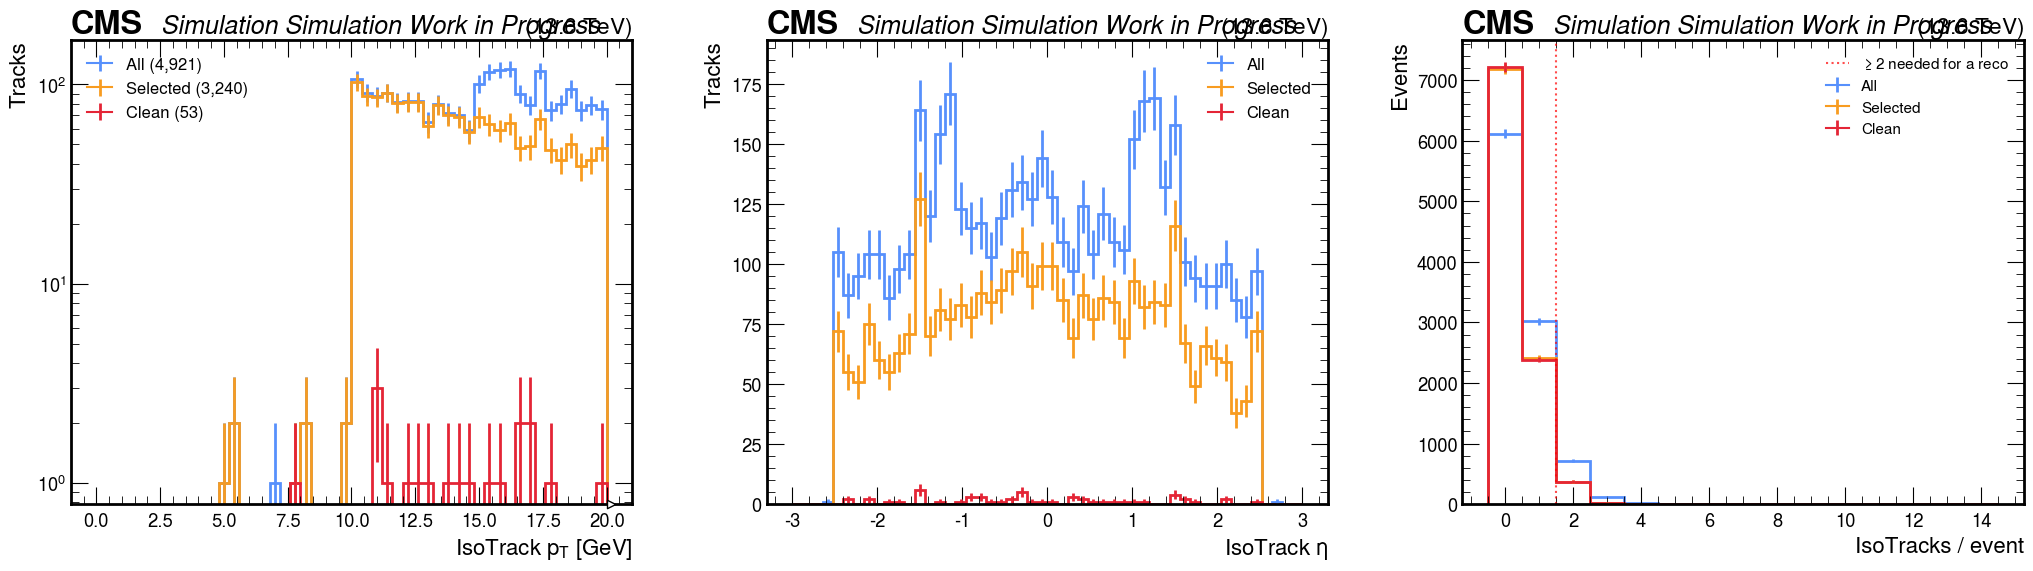

In [32]:
# ── IsoTrack pT and η spectra ──────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# All IsoTracks (before selection)
all_trk_pt  = ak.flatten(events["IsoTrack_pt"])
all_trk_eta = ak.flatten(events["IsoTrack_eta"])

# Selected IsoTracks (after quality cuts, before overlap removal)
sel_pt  = ak.flatten(sel_trk_pt)
sel_eta = ak.flatten(sel_trk_eta)

# Clean IsoTracks (after overlap removal) – use axis=None to drop Nones
clean_pt  = ak.flatten(clean_tracks.pt, axis=None)
clean_eta = ak.flatten(clean_tracks.eta, axis=None)

# 1. pT spectrum
h_pt_all   = hist.Hist(hist.axis.Regular(50, 0, 20, label=r"IsoTrack $p_T$ [GeV]"))
h_pt_sel   = hist.Hist(hist.axis.Regular(50, 0, 20, label=r"IsoTrack $p_T$ [GeV]"))
h_pt_clean = hist.Hist(hist.axis.Regular(50, 0, 20, label=r"IsoTrack $p_T$ [GeV]"))
h_pt_all.fill(all_trk_pt)
h_pt_sel.fill(sel_pt)
h_pt_clean.fill(clean_pt)
hep.histplot([h_pt_all, h_pt_sel, h_pt_clean], ax=axes[0],
             label=[f"All ({len(all_trk_pt):,})", f"Selected ({len(sel_pt):,})",
                    f"Clean ({len(clean_pt):,})"],
             histtype="step", linewidth=2)
axes[0].set_ylabel("Tracks")
axes[0].set_yscale("log")
axes[0].legend(fontsize=12)
cms_label(axes[0])

# 2. η spectrum
h_eta_all   = hist.Hist(hist.axis.Regular(50, -3, 3, label=r"IsoTrack $\eta$"))
h_eta_sel   = hist.Hist(hist.axis.Regular(50, -3, 3, label=r"IsoTrack $\eta$"))
h_eta_clean = hist.Hist(hist.axis.Regular(50, -3, 3, label=r"IsoTrack $\eta$"))
h_eta_all.fill(all_trk_eta)
h_eta_sel.fill(sel_eta)
h_eta_clean.fill(clean_eta)
hep.histplot([h_eta_all, h_eta_sel, h_eta_clean], ax=axes[1],
             label=["All", "Selected", "Clean"],
             histtype="step", linewidth=2)
axes[1].set_ylabel("Tracks")
axes[1].legend(fontsize=12)
cms_label(axes[1])

# 3. Multiplicity per event
h_n_all   = hist.Hist(hist.axis.Regular(15, -0.5, 14.5, label="IsoTracks / event"))
h_n_sel   = hist.Hist(hist.axis.Regular(15, -0.5, 14.5, label="IsoTracks / event"))
h_n_clean = hist.Hist(hist.axis.Regular(15, -0.5, 14.5, label="IsoTracks / event"))
h_n_all.fill(ak.num(events["IsoTrack_pt"]))
h_n_sel.fill(n_trk)
h_n_clean.fill(n_clean_trk)
hep.histplot([h_n_all, h_n_sel, h_n_clean], ax=axes[2],
             label=["All", "Selected", "Clean"],
             histtype="step", linewidth=2)
axes[2].set_ylabel("Events")
axes[2].axvline(1.5, color="red", ls=":", lw=1.5, alpha=0.7,
               label=r"$\geq 2$ needed for $a$ reco")
axes[2].legend(fontsize=11)
cms_label(axes[2])

save_and_show(fig, "isotracks_kinematics.png")

/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


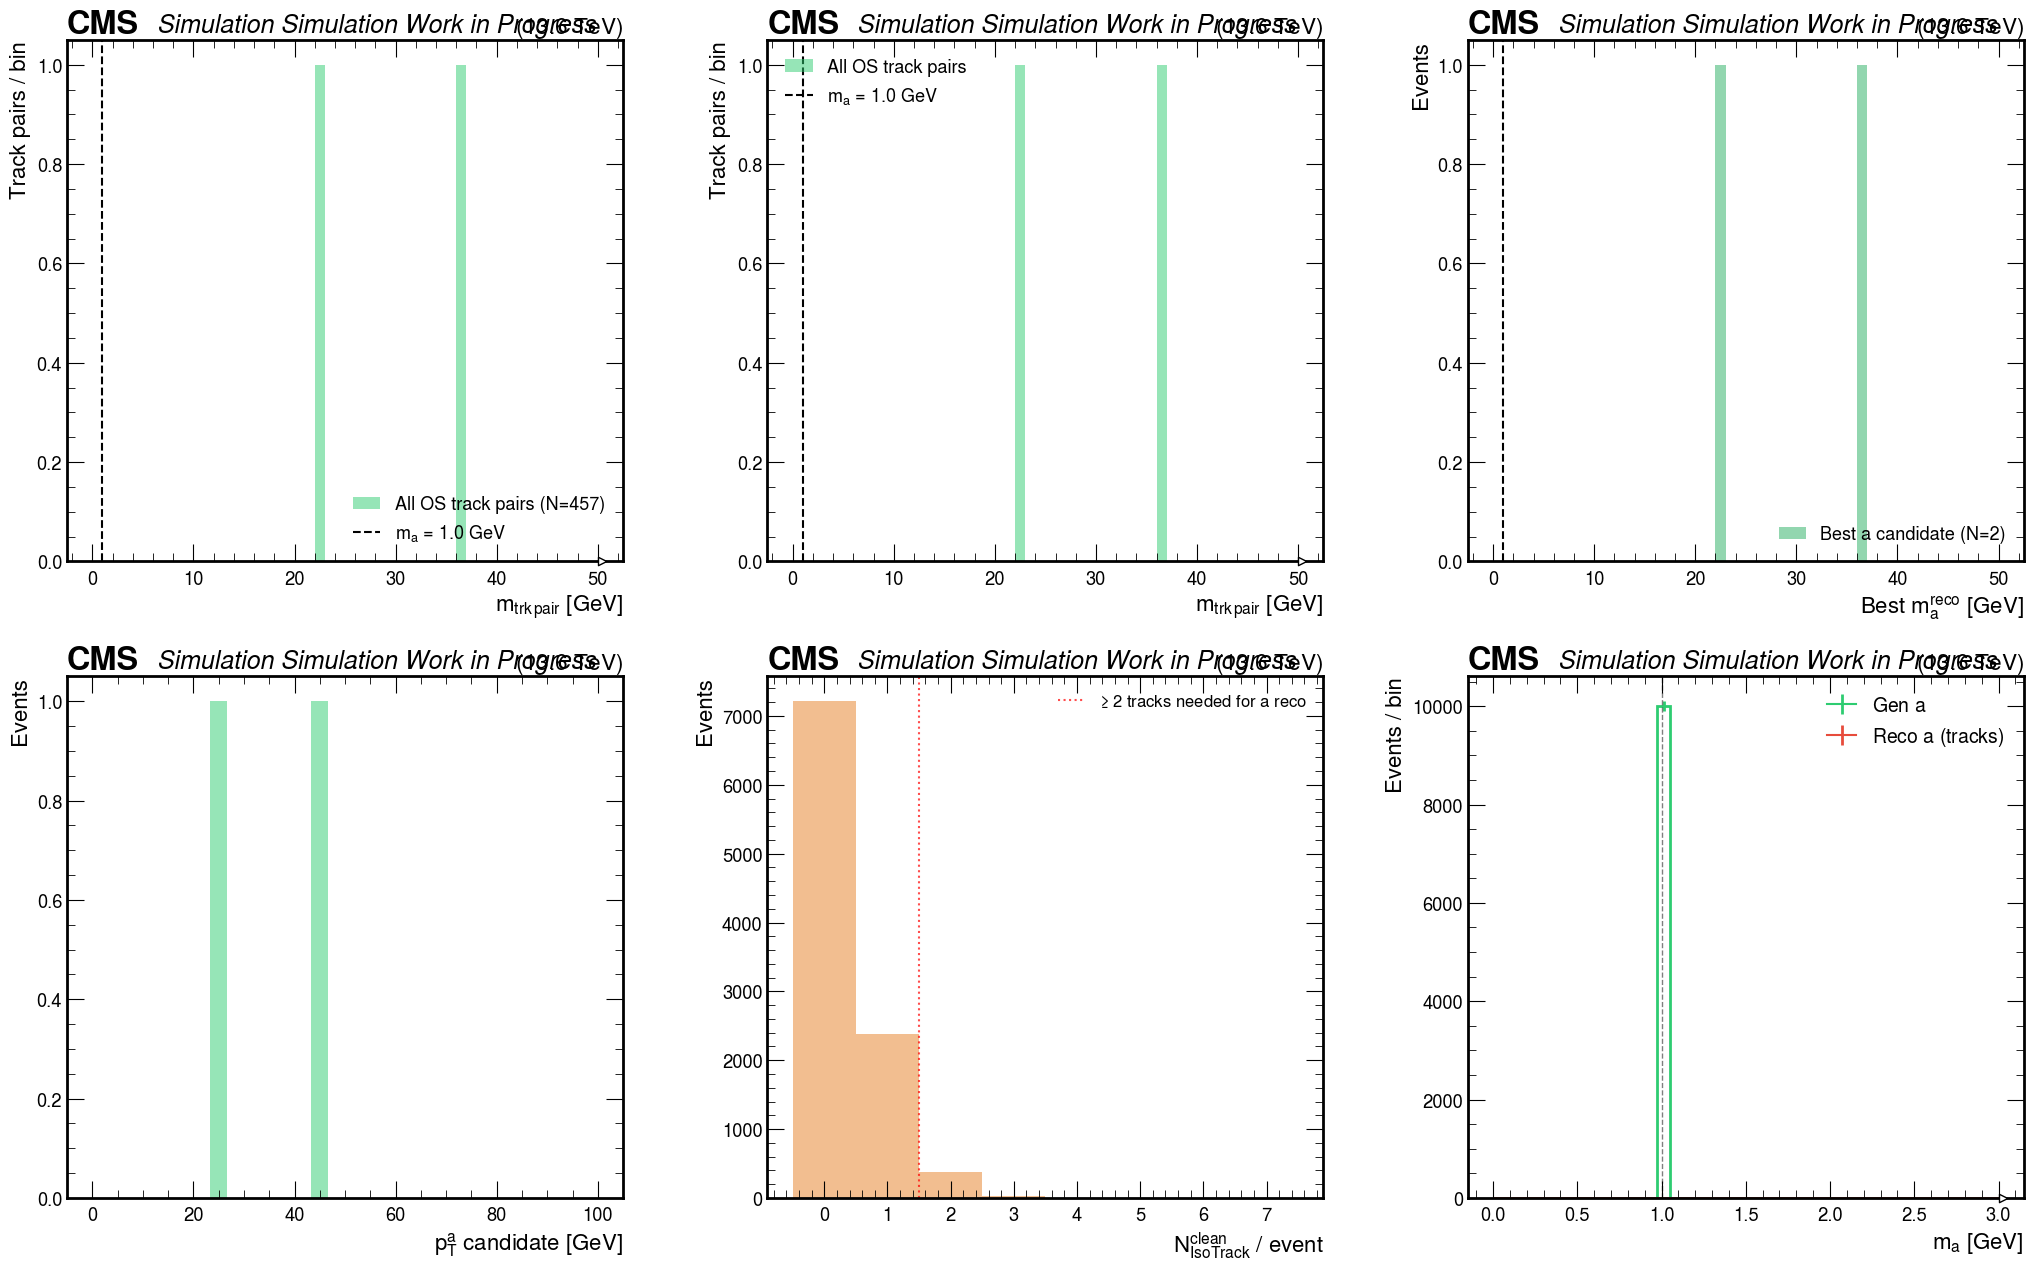

In [33]:
# ── a → track pair candidate plots ─────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(21, 13))

a_reco_m_arr = ak.to_numpy(a_cand_mass[has_a_reco]) if int(ak.sum(has_a_reco)) > 0 else np.array([])
a_reco_pt_arr = ak.to_numpy(a_cand_pt[has_a_reco]) if int(ak.sum(has_a_reco)) > 0 else np.array([])

# All OS track pair invariant mass
all_trk_pair_m = ak.flatten(trk_pair_mass)
if len(all_trk_pair_m) > 0:
    all_trk_pair_m = all_trk_pair_m.to_numpy()
else:
    all_trk_pair_m = np.array([])

h = hist.Hist(hist.axis.Regular(50, 0, 50, label=r"$m_{\mathrm{trk\,pair}}$ [GeV]"))
if len(all_trk_pair_m) > 0:
    h.fill(all_trk_pair_m)
hep.histplot(h, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71",
             label=f"All OS track pairs (N={len(all_trk_pair_m)})")
axes[0, 0].axvline(MASS_A, color="black", linestyle="--", linewidth=1.5,
                   label=f"$m_a$ = {MASS_A} GeV")
axes[0, 0].set_ylabel("Track pairs / bin")
axes[0, 0].legend(fontsize=13)
cms_label(axes[0, 0])

# Zoom near m_a
h = hist.Hist(hist.axis.Regular(50, 0, 50, label=r"$m_{\mathrm{trk\,pair}}$ [GeV]"))
if len(all_trk_pair_m) > 0:
    h.fill(all_trk_pair_m)
hep.histplot(h, ax=axes[0, 1], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71",
             label="All OS track pairs")
axes[0, 1].axvline(MASS_A, color="black", linestyle="--", linewidth=1.5,
                   label=f"$m_a$ = {MASS_A} GeV")
axes[0, 1].set_ylabel("Track pairs / bin")
axes[0, 1].legend(fontsize=13)
cms_label(axes[0, 1])

# Best a candidate mass per event
h = hist.Hist(hist.axis.Regular(50, 0, 50, label=r"Best $m_a^{\mathrm{reco}}$ [GeV]"))
if len(a_reco_m_arr) > 0:
    h.fill(a_reco_m_arr)
hep.histplot(h, ax=axes[0, 2], histtype="fill", alpha=0.5, color="#27ae60", edgecolor="#27ae60",
             label=f"Best a candidate (N={len(a_reco_m_arr)})")
axes[0, 2].axvline(MASS_A, color="black", linestyle="--", linewidth=1.5)
axes[0, 2].set_ylabel("Events")
axes[0, 2].legend(fontsize=13)
cms_label(axes[0, 2])

# a candidate pT
h = hist.Hist(hist.axis.Regular(30, 0, 100, label=r"$p_T^{a}$ candidate [GeV]"))
if len(a_reco_pt_arr) > 0:
    h.fill(a_reco_pt_arr)
hep.histplot(h, ax=axes[1, 0], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71")
axes[1, 0].set_ylabel("Events")
cms_label(axes[1, 0])

# IsoTrack multiplicity (after cleaning)
h = hist.Hist(hist.axis.Regular(8, -0.5, 7.5, label=r"$N_{\mathrm{IsoTrack}}^{\mathrm{clean}}$ / event"))
h.fill(ak.to_numpy(n_clean_trk))
hep.histplot(h, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#e67e22", edgecolor="#e67e22")
axes[1, 1].set_ylabel("Events")
axes[1, 1].axvline(1.5, color="red", linestyle=":", linewidth=1.5, alpha=0.7,
                   label=r"$\geq 2$ tracks needed for $a$ reco")
axes[1, 1].legend(fontsize=12)
cms_label(axes[1, 1])

# Gen vs reco a mass comparison
h_gen_a = hist.Hist(hist.axis.Regular(40, 0, 3, label=r"$m_a$ [GeV]"))
h_reco_a = hist.Hist(hist.axis.Regular(40, 0, 3, label=r"$m_a$ [GeV]"))
h_gen_a.fill(a_m)
if len(a_reco_m_arr) > 0:
    h_reco_a.fill(a_reco_m_arr)
hep.histplot(h_gen_a, ax=axes[1, 2], histtype="step", linewidth=2, color="#2ecc71", label="Gen $a$")
hep.histplot(h_reco_a, ax=axes[1, 2], histtype="step", linewidth=2, color="#e74c3c",
             label=r"Reco $a$ (tracks)")
axes[1, 2].axvline(MASS_A, color="black", linestyle="--", linewidth=1, alpha=0.5)
axes[1, 2].set_ylabel("Events / bin")
axes[1, 2].legend(fontsize=14)
cms_label(axes[1, 2])

save_and_show(fig, "reco_a_candidate.png")

Events with both Z and a candidates: 2


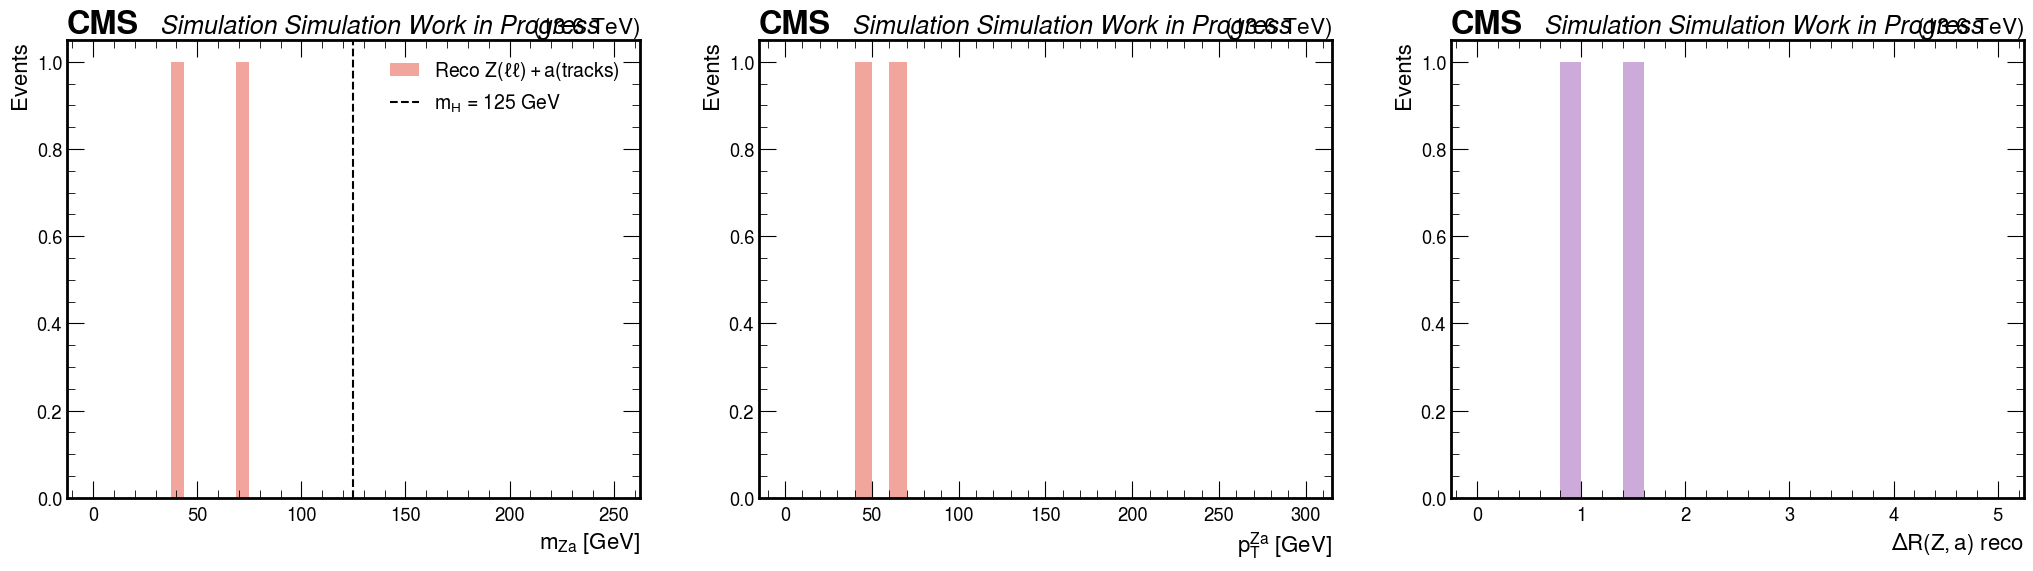

In [34]:
# ── Higgs → Za reconstruction ──────────────────────────────────────────────────
# Combine reco Z candidate (from ℓℓ) + reco a candidate (from IsoTracks)
has_both = has_z & has_a_reco

z_vec_for_h = vector.zip({
    "pt":   z_pt[has_both],
    "eta":  z_eta[has_both],
    "phi":  z_phi[has_both],
    "mass": z_mass[has_both],
})
a_vec_for_h = vector.zip({
    "pt":   a_cand_pt[has_both],
    "eta":  a_cand_eta[has_both],
    "phi":  a_cand_phi[has_both],
    "mass": a_cand_mass[has_both],
})

h_cand = z_vec_for_h + a_vec_for_h

print(f"Events with both Z and a candidates: {int(ak.sum(has_both))}")

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

if int(ak.sum(has_both)) > 0:
    h_cand_m = ak.to_numpy(h_cand.mass)
    h_cand_pt = ak.to_numpy(h_cand.pt)
    dr_za_reco = ak.to_numpy(z_vec_for_h.deltaR(a_vec_for_h))
else:
    h_cand_m = np.array([])
    h_cand_pt = np.array([])
    dr_za_reco = np.array([])

# H candidate mass
h = hist.Hist(hist.axis.Regular(40, 0, 250, label=r"$m_{Za}$ [GeV]"))
if len(h_cand_m) > 0:
    h.fill(h_cand_m)
hep.histplot(h, ax=axes[0], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c",
             label=r"Reco $Z(\ell\ell) + a(\mathrm{tracks})$")
axes[0].axvline(125.0, color="black", linestyle="--", linewidth=1.5, label=r"$m_H$ = 125 GeV")
axes[0].set_ylabel("Events")
axes[0].legend(fontsize=14)
cms_label(axes[0])

# H candidate pT
h = hist.Hist(hist.axis.Regular(30, 0, 300, label=r"$p_T^{Za}$ [GeV]"))
if len(h_cand_pt) > 0:
    h.fill(h_cand_pt)
hep.histplot(h, ax=axes[1], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1].set_ylabel("Events")
cms_label(axes[1])

# ΔR(Z, a) reco
h = hist.Hist(hist.axis.Regular(25, 0, 5, label=r"$\Delta R(Z, a)$ reco"))
if len(dr_za_reco) > 0:
    h.fill(dr_za_reco)
hep.histplot(h, ax=axes[2], histtype="fill", alpha=0.5, color="#9b59b6", edgecolor="#9b59b6")
axes[2].set_ylabel("Events")
cms_label(axes[2])

save_and_show(fig, "reco_higgs_candidate.png")

## Pseudoscalar $a$ Reconstruction from PF Candidates

The `IsoTrack` collection in NanoAOD is sparse by design (only isolated tracks are stored).
For a low-mass pseudoscalar $a \to \pi^+\pi^-$, the decay products are soft and may
not pass isolation requirements.

Here we use the **PFCands** (particle flow candidates) collection, which stores *all*
charged PF candidates from the primary vertex. This gives much higher track multiplicity
and better sensitivity to soft, collimated $a$ decays.

We form **opposite-sign charged PFCand pairs** (after lepton overlap removal),
assign each track the pion mass, and apply three targeted cuts to suppress
combinatorial fakes:

1. **Collimation**: $\Delta R < 0.2$ — at $m_a = 1$ GeV with $p_T(a) \sim 20\text{–}60$ GeV
   the true opening angle is $\Delta R \sim 2m_a/p_T \sim 0.03\text{–}0.1$.
2. **Mass window**: $|m(\pi\pi) - m_a| < 0.3$ GeV.
3. **Pair $p_T > 15$ GeV** — the true $a$ has $p_T \sim 20\text{–}60$ GeV;
   random soft-track fakes typically have $p_T \lesssim 5$ GeV.

Among surviving candidates we select the **highest-$p_T$ pair** rather than
the one closest to $m_a$, since the latter is biased toward soft combinatorial fakes.

/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer wei

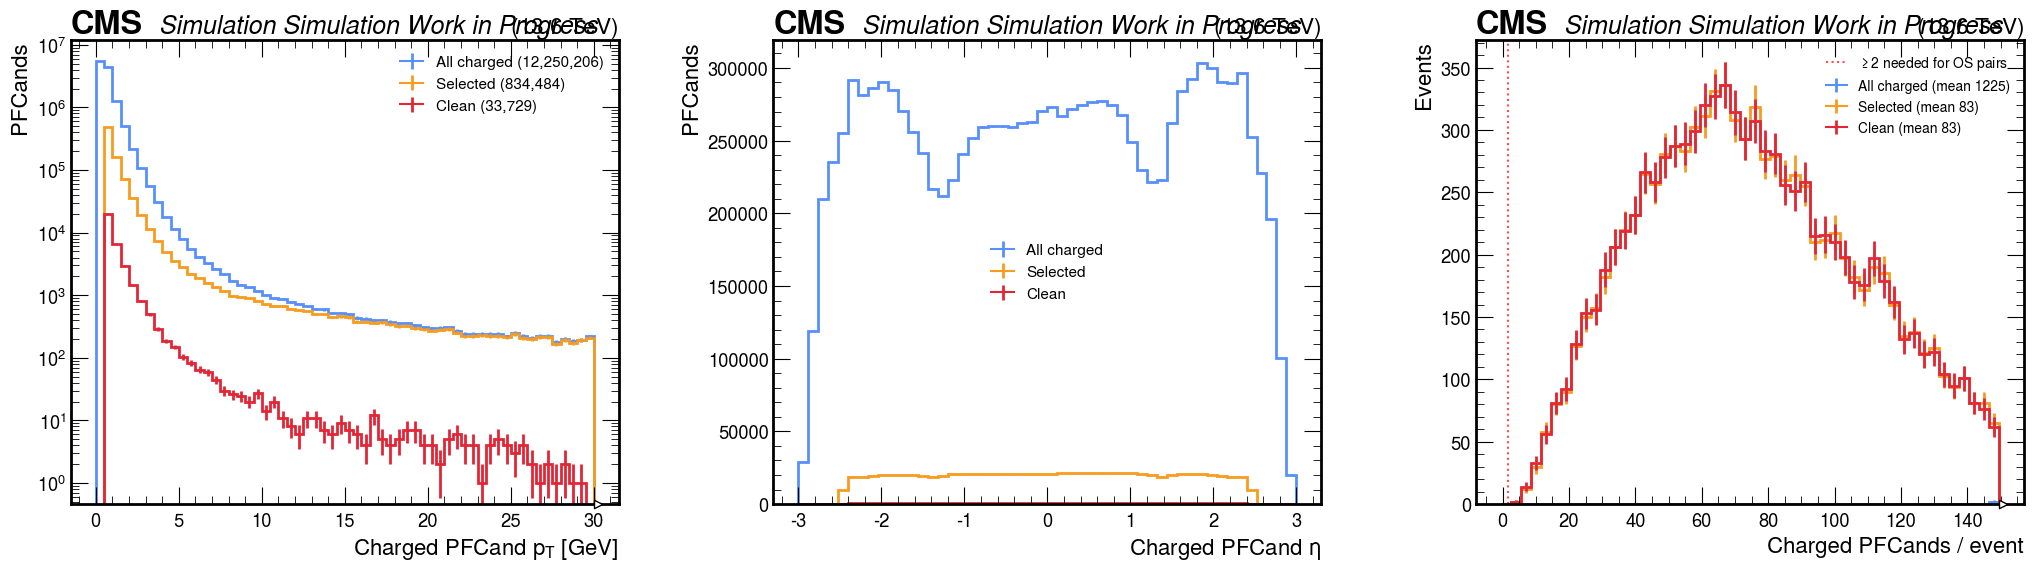

In [35]:
# ── Charged PFCands pT, η, and multiplicity spectra ────────────────────────────
if not HAS_PFCANDS:
    print("⚠ PFCands not available — skipping kinematic plots.")
else:
    # Reload minimal PFCands branches for plotting (the full arrays were freed above)
    _pf_plot_branches = [k for k in pf_branches_to_read
                         if any(s in k for s in ["_pt", "_eta", "_phi", "_mass",
                                                 "_charge", "_fromPV", "_dz", "_d0",
                                                 "_pvAssocQuality"])]
    _pf = uproot.concatenate(
        {f: "Events" for f in files},
        expressions=_pf_plot_branches,
        library="ak",
    )

    _pf_pt     = _pf["PFCands_pt"]
    _pf_eta    = _pf["PFCands_eta"]
    _pf_charge = _pf["PFCands_charge"]
    _pf_pv = (_pf["PFCands_fromPV"] if "PFCands_fromPV" in _pf.fields
              else _pf["PFCands_pvAssocQuality"] if "PFCands_pvAssocQuality" in _pf.fields
              else ak.ones_like(_pf_pt, dtype=int) * 3)
    _pf_dz = _pf["PFCands_dz"] if "PFCands_dz" in _pf.fields else None
    _pf_d0 = _pf["PFCands_d0"] if "PFCands_d0" in _pf.fields else None

    # ── All charged PFCands ──
    _charged = (_pf_charge != 0)
    all_pf_pt  = ak.flatten(_pf_pt[_charged])
    all_pf_eta = ak.flatten(_pf_eta[_charged])
    n_all_pf   = ak.num(_pf_pt[_charged])

    # ── Selected charged PFCands (same cuts as reconstruction cell) ──
    _sel = (_charged
            & (_pf_pt > 0.5)
            & (np.abs(_pf_eta) < 2.5)
            & (_pf_pv >= 1))
    if _pf_dz is not None:
        _sel = _sel & (np.abs(_pf_dz) < 0.5)
    if _pf_d0 is not None:
        _sel = _sel & (np.abs(_pf_d0) < 0.1)

    sel_pf_pt  = ak.flatten(_pf_pt[_sel])
    sel_pf_eta = ak.flatten(_pf_eta[_sel])
    n_sel_pf   = ak.num(_pf_pt[_sel])

    # ── Clean charged PFCands (after lepton overlap removal) ──
    _sel_tracks = vector.zip({
        "pt":   _pf_pt[_sel],
        "eta":  _pf_eta[_sel],
        "phi":  _pf["PFCands_phi"][_sel],
        "mass": _pf["PFCands_mass"][_sel],
    })
    _not_mu = remove_overlap(_sel_tracks, sel_mu, dr_cut=0.3)
    _not_el = remove_overlap(_sel_tracks, sel_el, dr_cut=0.3)
    _clean = _sel_tracks[_not_mu & _not_el]

    clean_pf_pt  = ak.flatten(_clean.pt, axis=None)
    clean_pf_eta = ak.flatten(_clean.eta, axis=None)
    n_clean_pf_plot = ak.num(_clean)

    # ── Plot ──
    fig, axes = plt.subplots(1, 3, figsize=(21, 6))

    # 1. pT spectrum
    h0 = hist.Hist(hist.axis.Regular(60, 0, 30, label=r"Charged PFCand $p_T$ [GeV]"))
    h1 = hist.Hist(hist.axis.Regular(60, 0, 30, label=r"Charged PFCand $p_T$ [GeV]"))
    h2 = hist.Hist(hist.axis.Regular(60, 0, 30, label=r"Charged PFCand $p_T$ [GeV]"))
    h0.fill(all_pf_pt); h1.fill(sel_pf_pt); h2.fill(clean_pf_pt)
    hep.histplot([h0, h1, h2], ax=axes[0],
                 label=[f"All charged ({len(all_pf_pt):,})",
                        f"Selected ({len(sel_pf_pt):,})",
                        f"Clean ({len(clean_pf_pt):,})"],
                 histtype="step", linewidth=2)
    axes[0].set_ylabel("PFCands")
    axes[0].set_yscale("log")
    axes[0].legend(fontsize=11)
    cms_label(axes[0])

    # 2. η spectrum
    h0e = hist.Hist(hist.axis.Regular(50, -3, 3, label=r"Charged PFCand $\eta$"))
    h1e = hist.Hist(hist.axis.Regular(50, -3, 3, label=r"Charged PFCand $\eta$"))
    h2e = hist.Hist(hist.axis.Regular(50, -3, 3, label=r"Charged PFCand $\eta$"))
    h0e.fill(all_pf_eta); h1e.fill(sel_pf_eta); h2e.fill(clean_pf_eta)
    hep.histplot([h0e, h1e, h2e], ax=axes[1],
                 label=["All charged", "Selected", "Clean"],
                 histtype="step", linewidth=2)
    axes[1].set_ylabel("PFCands")
    axes[1].legend(fontsize=11)
    cms_label(axes[1])

    # 3. Multiplicity per event
    h0n = hist.Hist(hist.axis.Regular(50, -0.5, 149.5, label="Charged PFCands / event"))
    h1n = hist.Hist(hist.axis.Regular(50, -0.5, 149.5, label="Charged PFCands / event"))
    h2n = hist.Hist(hist.axis.Regular(50, -0.5, 149.5, label="Charged PFCands / event"))
    h0n.fill(n_all_pf); h1n.fill(n_sel_pf); h2n.fill(n_clean_pf_plot)
    hep.histplot([h0n, h1n, h2n], ax=axes[2],
                 label=[f"All charged (mean {float(ak.mean(n_all_pf)):.0f})",
                        f"Selected (mean {float(ak.mean(n_sel_pf)):.0f})",
                        f"Clean (mean {float(ak.mean(n_clean_pf_plot)):.0f})"],
                 histtype="step", linewidth=2)
    axes[2].set_ylabel("Events")
    axes[2].axvline(1.5, color="red", ls=":", lw=1.5, alpha=0.7,
                    label=r"$\geq 2$ needed for OS pairs")
    axes[2].legend(fontsize=10)
    cms_label(axes[2])

    save_and_show(fig, "pfcands_kinematics.png")

    # Cleanup
    del (_pf, _pf_pt, _pf_eta, _pf_charge, _pf_pv, _pf_dz, _pf_d0,
         _charged, _sel, _sel_tracks, _not_mu, _not_el, _clean)
    gc.collect()

In [36]:
# ── Reconstruct a → π⁺π⁻ using PF Candidates (OS pairs) ─────────────────────
# PFCands are loaded separately from the core events to avoid holding everything
# in memory at once. The OS-pair computation is chunked to prevent the O(N²)
# pair explosion.

_n = len(events)

if not HAS_PFCANDS:
    print("⚠ PFCands collection not found in this NanoAOD file.")
    print("  Skipping PFCands-based reconstruction.")
    _dummy = np.zeros(_n, dtype=bool)
    _neg   = np.full(_n, -999.0)
    has_a_pf_reco = _dummy
    a_pf_mass = a_pf_pt = a_pf_eta = a_pf_phi = _neg
    n_clean_pf = ak.Array(np.zeros(_n, dtype=int))
else:
    print("✓ Loading PFCands branches (separate from core events)...\n")

    # ── Step 1: Load PFCands and apply selection ───────────────────────────────
    pf_data = uproot.concatenate(
        {f: "Events" for f in files},
        expressions=pf_branches_to_read,
        library="ak",
    )
    assert len(pf_data) == _n, f"Event count mismatch: PFCands={len(pf_data)}, events={_n}"
    print(f"  Loaded PFCands for {_n} events")

    pf_pt     = pf_data["PFCands_pt"]
    pf_eta    = pf_data["PFCands_eta"]
    pf_phi    = pf_data["PFCands_phi"]
    pf_mass   = pf_data["PFCands_mass"]
    pf_charge = pf_data["PFCands_charge"]

    pf_pv = (pf_data["PFCands_fromPV"] if "PFCands_fromPV" in pf_data.fields
             else pf_data["PFCands_pvAssocQuality"] if "PFCands_pvAssocQuality" in pf_data.fields
             else ak.ones_like(pf_pt, dtype=int) * 3)
    pf_dz = pf_data["PFCands_dz"] if "PFCands_dz" in pf_data.fields else None
    pf_d0 = pf_data["PFCands_d0"] if "PFCands_d0" in pf_data.fields else None

    pf_sel = (
        (pf_charge != 0)
        & (pf_pt > 0.5)
        & (np.abs(pf_eta) < 2.5)
        & (pf_pv >= 1)
    )
    if pf_dz is not None:
        pf_sel = pf_sel & (np.abs(pf_dz) < 0.5)
    if pf_d0 is not None:
        pf_sel = pf_sel & (np.abs(pf_d0) < 0.1)

    pf_tracks = vector.zip({
        "pt":   pf_pt[pf_sel],
        "eta":  pf_eta[pf_sel],
        "phi":  pf_phi[pf_sel],
        "mass": ak.full_like(pf_mass[pf_sel], M_PION),
    })
    sel_pf_q = pf_charge[pf_sel]

    del pf_data, pf_pt, pf_eta, pf_phi, pf_mass, pf_charge, pf_pv, pf_dz, pf_d0, pf_sel
    gc.collect()

    n_pf = ak.num(pf_tracks)
    print(f"  PFCands after selection: {int(ak.sum(n_pf))} total, "
          f"mean {float(ak.mean(n_pf)):.1f}/event")

    # ── Lepton overlap removal ─────────────────────────────────────────────────
    not_mu_overlap_pf = remove_overlap(pf_tracks, sel_mu, dr_cut=0.3)
    not_el_overlap_pf = remove_overlap(pf_tracks, sel_el, dr_cut=0.3)
    clean_pf   = pf_tracks[not_mu_overlap_pf & not_el_overlap_pf]
    clean_pf_q = sel_pf_q[not_mu_overlap_pf & not_el_overlap_pf]
    del pf_tracks, sel_pf_q, not_mu_overlap_pf, not_el_overlap_pf
    gc.collect()

    n_clean_pf = ak.num(clean_pf)
    print(f"  After lepton removal: mean {float(ak.mean(n_clean_pf)):.1f}/event, "
          f"≥2 in {int(ak.sum(n_clean_pf >= 2))} events")
    print(f"  cf. IsoTrack (clean): mean {float(ak.mean(n_clean_trk)):.1f}/event")

    # ── OS pair computation (chunked) ──────────────────────────────────────────
    print(f"\n{'='*60}")
    print(f"OS pair reco: ΔR < 0.2, |m−m_a| < 0.3 GeV, pT > 15 GeV, highest-pT (chunk = {PAIR_CHUNK_SIZE})")

    a_pf_mass_np = np.full(_n, -999.0)
    a_pf_pt_np   = np.full(_n, -999.0)
    a_pf_eta_np  = np.full(_n, -999.0)
    a_pf_phi_np  = np.full(_n, -999.0)
    has_a_pf_np  = np.zeros(_n, dtype=bool)

    for chunk_start in range(0, _n, PAIR_CHUNK_SIZE):
        chunk_end = min(chunk_start + PAIR_CHUNK_SIZE, _n)
        sl = slice(chunk_start, chunk_end)

        chunk_pf = clean_pf[sl]
        chunk_q  = clean_pf_q[sl]

        pairs = ak.argcombinations(chunk_pf, 2, axis=1)
        n_pairs = int(ak.sum(ak.num(pairs)))
        if n_pairs == 0:
            print(f"  Chunk {chunk_start:>6d}–{chunk_end:<6d}: 0 pairs (skipped)")
            continue

        pi0, pi1 = ak.unzip(pairs)
        pf0 = chunk_pf[pi0]
        pf1 = chunk_pf[pi1]
        q0  = chunk_q[pi0]
        q1  = chunk_q[pi1]

        os_mask = (q0 * q1 < 0)
        dr_pair = pf0.deltaR(pf1)

        # ── Selection cuts ──────────────────────────────────────────────────
        # 1. Opposite-sign + collimation: real a→ππ at mA~1 GeV have
        #    ΔR ~ 2*mA/pT(a) ≈ 0.03–0.1.  ΔR < 0.2 is generous.
        # 2. Mass window: |m(ππ) − m_a| < 0.3 GeV
        # 3. Pair pT > 15 GeV (real a has pT ~ 20–60 GeV; fakes are soft)
        # 4. Select the highest-pT surviving pair (less biased than
        #    "closest to m_a" which preferentially picks soft fakes).
        coll_mask = ak.fill_none(os_mask & (dr_pair < 0.2), False)
        pf_coll_sum = pf0[coll_mask] + pf1[coll_mask]

        mass_ok = np.abs(pf_coll_sum.mass - MASS_A) < 0.3
        pt_ok   = pf_coll_sum.pt > 15.0
        final_cands = pf_coll_sum[ak.fill_none(mass_ok & pt_ok, False)]
        has_cand = ak.num(final_cands) > 0

        if ak.any(has_cand):
            best_idx = ak.argmax(final_cands.pt, axis=1, keepdims=True)
            bv_best  = final_cands[best_idx]
            has_a_pf_np[sl] = ak.to_numpy(has_cand)
            a_pf_mass_np[sl] = ak.to_numpy(ak.fill_none(ak.firsts(bv_best.mass), -999))
            a_pf_pt_np[sl]   = ak.to_numpy(ak.fill_none(ak.firsts(bv_best.pt), -999))
            a_pf_eta_np[sl]  = ak.to_numpy(ak.fill_none(ak.firsts(bv_best.eta), -999))
            a_pf_phi_np[sl]  = ak.to_numpy(ak.fill_none(ak.firsts(bv_best.phi), -999))

        del pairs, pi0, pi1, pf0, pf1, q0, q1, os_mask, dr_pair, coll_mask
        del pf_coll_sum, final_cands
        gc.collect()
        print(f"  Chunk {chunk_start:>6d}–{chunk_end:<6d}: {n_pairs:>10,d} pairs processed")

    # Convert to awkward arrays
    a_pf_mass = ak.Array(a_pf_mass_np)
    a_pf_pt   = ak.Array(a_pf_pt_np)
    a_pf_eta  = ak.Array(a_pf_eta_np)
    a_pf_phi  = ak.Array(a_pf_phi_np)
    has_a_pf  = ak.Array(has_a_pf_np)

    del (a_pf_mass_np, a_pf_pt_np, a_pf_eta_np, a_pf_phi_np,
         has_a_pf_np, clean_pf, clean_pf_q)

    has_a_pf_reco = has_a_pf & (a_pf_mass > 0)
    print(f"\n  IsoTrack OS pairs:      {int(ak.sum(has_a_reco)):>5}")
    print(f"  PFCands selected pairs: {int(ak.sum(has_a_pf_reco)):>5}")

✓ Loading PFCands branches (separate from core events)...

  Loaded PFCands for 10000 events
  PFCands after selection: 834484 total, mean 83.4/event
  After lepton removal: mean 83.2/event, ≥2 in 10000 events
  cf. IsoTrack (clean): mean 0.3/event

OS pair reco: ΔR < 0.2, |m−m_a| < 0.3 GeV, pT > 15 GeV, highest-pT (chunk = 5000)
  Chunk      0–5000  : 21,997,135 pairs processed
  Chunk   5000–10000 : 21,548,331 pairs processed

  IsoTrack OS pairs:          2
  PFCands selected pairs:    94


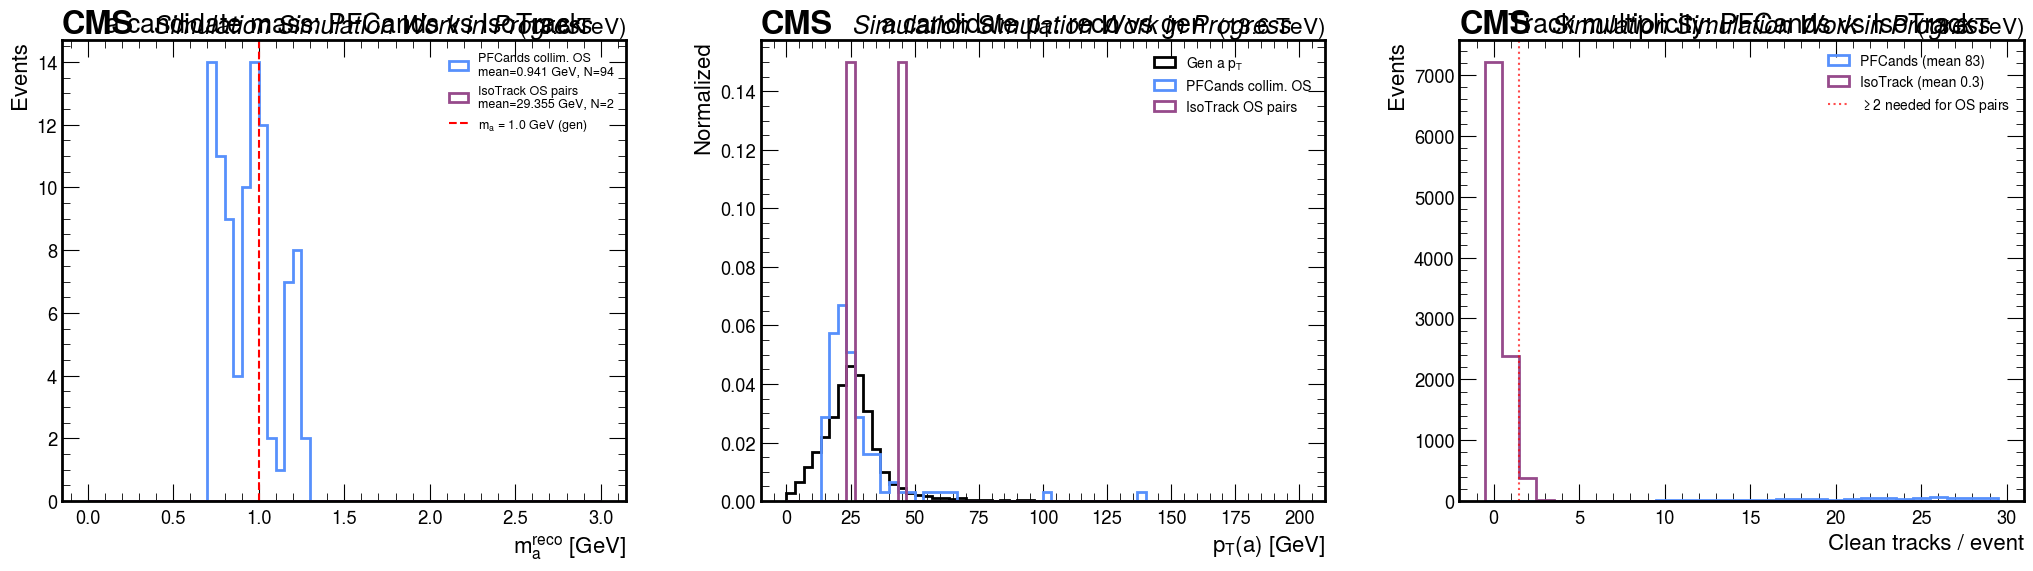

In [37]:
# ── PFCands a-candidate plots ───────────────────────────────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# [0] Mass distribution
ax = axes[0]
m_pf = ak.to_numpy(a_pf_mass[has_a_pf_reco])
if len(m_pf) > 0:
    ax.hist(m_pf, bins=60, range=(0, 3.0), histtype="step", linewidth=2, color="C0",
            label=f"PFCands collim. OS\nmean={np.mean(m_pf):.3f} GeV, N={len(m_pf)}")
m_iso = ak.to_numpy(a_cand_mass[has_a_reco])
if len(m_iso) > 0:
    ax.hist(m_iso, bins=60, range=(0, 3.0), histtype="step", linewidth=2, color="C3",
            label=f"IsoTrack OS pairs\nmean={np.mean(m_iso):.3f} GeV, N={len(m_iso)}")
ax.axvline(MASS_A, color="red", linestyle="--", linewidth=1.5, label=f"$m_a$ = {MASS_A} GeV (gen)")
ax.set_xlabel("$m_a^{\\mathrm{reco}}$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("$a$ candidate mass: PFCands vs IsoTrack")
ax.legend(fontsize=9)
cms_label(ax)

# [1] pT: reco vs gen
ax = axes[1]
bins_pt = np.linspace(0, 200, 61)
gen_a_pt_vals = ak.to_numpy(ak.fill_none(ak.firsts(gen_a.pt), -999))
gen_a_pt_valid = gen_a_pt_vals[gen_a_pt_vals > 0]
ax.hist(gen_a_pt_valid, bins=bins_pt, histtype="step", linewidth=2, color="black",
        density=True, label="Gen $a$ $p_T$")
pt_pf = ak.to_numpy(a_pf_pt[has_a_pf_reco])
if len(pt_pf) > 0:
    ax.hist(pt_pf, bins=bins_pt, histtype="step", linewidth=2, color="C0",
            density=True, label="PFCands collim. OS")
pt_iso = ak.to_numpy(a_cand_pt[has_a_reco])
if len(pt_iso) > 0:
    ax.hist(pt_iso, bins=bins_pt, histtype="step", linewidth=2, color="C3",
            density=True, label="IsoTrack OS pairs")
ax.set_xlabel("$p_T(a)$ [GeV]")
ax.set_ylabel("Normalized")
ax.set_title("$a$ candidate $p_T$: reco vs gen")
ax.legend(fontsize=10)
cms_label(ax)

# [2] Track multiplicity comparison
ax = axes[2]
ax.hist(ak.to_numpy(n_clean_pf), bins=np.arange(-0.5, 30.5, 1), histtype="step",
        linewidth=2, color="C0", label=f"PFCands (mean {float(ak.mean(n_clean_pf)):.0f})")
ax.hist(ak.to_numpy(n_clean_trk), bins=np.arange(-0.5, 30.5, 1), histtype="step",
        linewidth=2, color="C3", label=f"IsoTrack (mean {float(ak.mean(n_clean_trk)):.1f})")
ax.axvline(1.5, color="red", ls=":", lw=1.5, alpha=0.7,
           label=r"$\geq 2$ needed for OS pairs")
ax.set_xlabel("Clean tracks / event")
ax.set_ylabel("Events")
ax.set_title("Track multiplicity: PFCands vs IsoTrack")
ax.legend(fontsize=10)
cms_label(ax)

save_and_show(fig, "pfcands_a_candidates.png")

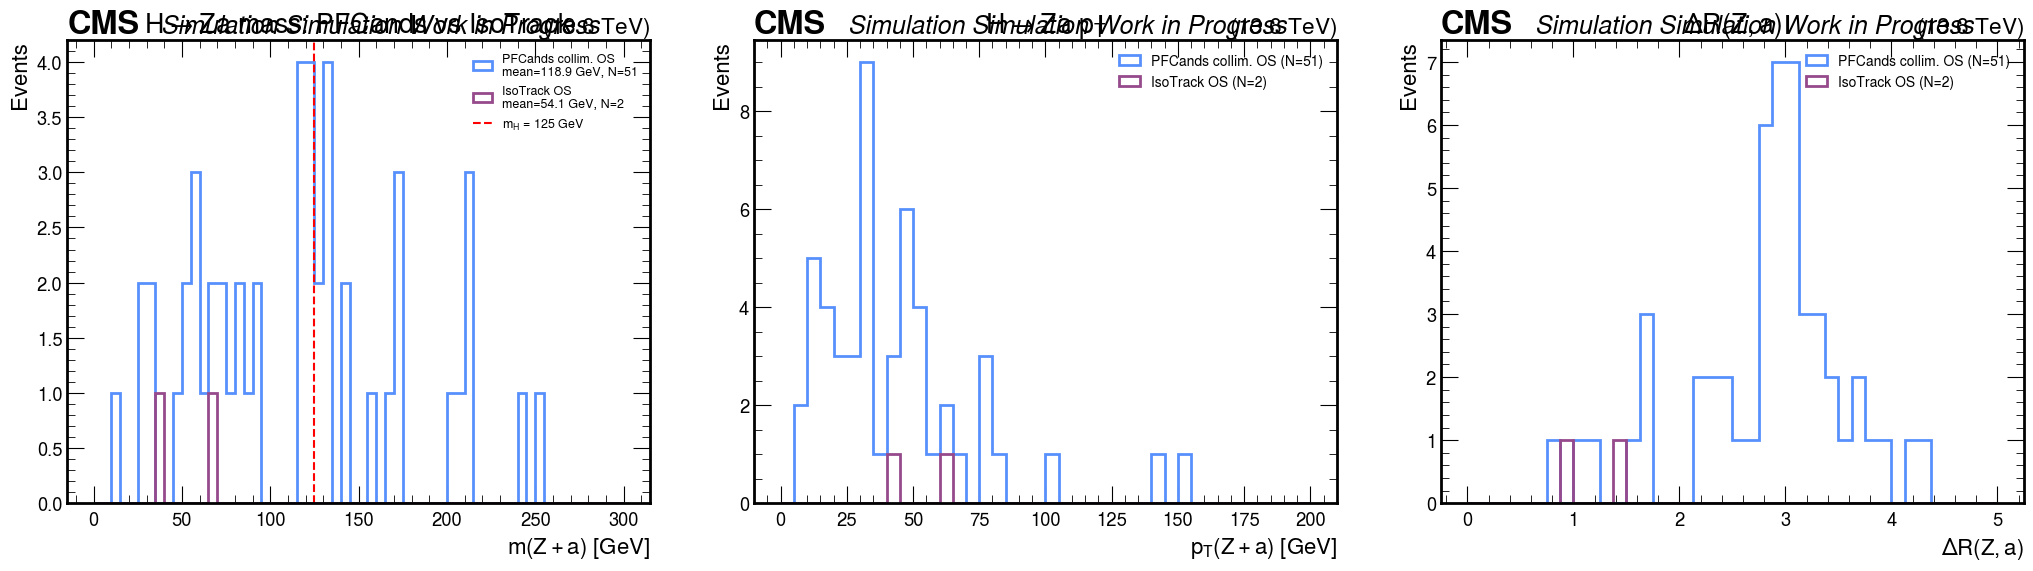


H → Za reconstruction:
  PFCands collim. OS: N=51, mean m_H = 118.9 GeV
  IsoTrack OS pairs: N=2, mean m_H = 54.1 GeV


In [38]:
# ── H → Z a reconstruction using PFCands ────────────────────────────────────────
# Combine the reco Z with the PFCands a-candidate (OS pairs) to reconstruct H.

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Build Z 4-vector (same as used in IsoTrack H reconstruction)
z_vec_for_h = vector.zip({
    "pt": z_pt, "eta": z_eta, "phi": z_phi, "mass": z_mass,
})

# ── PFCands OS pairs ─────────────────────────────────────────────────────────
a_pf_4v = vector.zip({
    "pt": a_pf_pt, "eta": a_pf_eta, "phi": a_pf_phi, "mass": a_pf_mass,
})
h_pf_sel = has_z & has_a_pf_reco
h_pf_4v = z_vec_for_h[h_pf_sel] + a_pf_4v[h_pf_sel]
h_pf_m = ak.to_numpy(h_pf_4v.mass)
h_pf_pt = ak.to_numpy(h_pf_4v.pt)

# [0] m(Za) — PFCands vs IsoTrack
ax = axes[0]
bins_h = np.linspace(0, 300, 61)
if len(h_pf_m) > 0:
    ax.hist(h_pf_m, bins=bins_h, histtype="step", linewidth=2, color="C0",
            label=f"PFCands collim. OS\nmean={np.mean(h_pf_m):.1f} GeV, N={len(h_pf_m)}")
if len(h_cand_m) > 0:
    ax.hist(h_cand_m, bins=bins_h, histtype="step", linewidth=2, color="C3",
            label=f"IsoTrack OS\nmean={np.mean(h_cand_m):.1f} GeV, N={len(h_cand_m)}")
ax.axvline(125.0, color="red", linestyle="--", linewidth=1.5, label="$m_H$ = 125 GeV")
ax.set_xlabel("$m(Z + a)$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("$H \\to Za$ mass: PFCands vs IsoTrack")
ax.legend(fontsize=9)
cms_label(ax)

# [1] pT(Za)
ax = axes[1]
if len(h_pf_pt) > 0:
    ax.hist(h_pf_pt, bins=np.linspace(0, 200, 41), histtype="step", linewidth=2, color="C0",
            label=f"PFCands collim. OS (N={len(h_pf_pt)})")
if len(h_cand_pt) > 0:
    ax.hist(h_cand_pt, bins=np.linspace(0, 200, 41), histtype="step", linewidth=2, color="C3",
            label=f"IsoTrack OS (N={len(h_cand_pt)})")
ax.set_xlabel("$p_T(Z + a)$ [GeV]")
ax.set_ylabel("Events")
ax.set_title("$H \\to Za$ $p_T$")
ax.legend(fontsize=10)
cms_label(ax)

# [2] ΔR(Z, a) — PFCands
ax = axes[2]
if ak.any(h_pf_sel):
    z_sel = z_vec_for_h[h_pf_sel]
    a_sel = a_pf_4v[h_pf_sel]
    dr_za = ak.to_numpy(z_sel.deltaR(a_sel))
    ax.hist(dr_za, bins=40, range=(0, 5), histtype="step", linewidth=2, color="C0",
            label=f"PFCands collim. OS (N={len(dr_za)})")
if len(dr_za_reco) > 0:
    ax.hist(dr_za_reco, bins=40, range=(0, 5), histtype="step", linewidth=2, color="C3",
            label=f"IsoTrack OS (N={len(dr_za_reco)})")
ax.set_xlabel("$\\Delta R(Z, a)$")
ax.set_ylabel("Events")
ax.set_title("$\\Delta R(Z, a)$")
ax.legend(fontsize=10)
cms_label(ax)

save_and_show(fig, "pfcands_hza_reconstruction.png")

print(f"\nH → Za reconstruction:")
if len(h_pf_m) > 0:
    print(f"  PFCands collim. OS: N={len(h_pf_m)}, mean m_H = {np.mean(h_pf_m):.1f} GeV")
if len(h_cand_m) > 0:
    print(f"  IsoTrack OS pairs: N={len(h_cand_m)}, mean m_H = {np.mean(h_cand_m):.1f} GeV")

### Brute-force $H \to Za$ reconstruction (Higgs-mass constraint)

Alternative approach: instead of first selecting the best $a$ candidate and then
combining with the $Z$, we directly optimise $m(Z + \pi\pi)$.

For every event with a reconstructed $Z$, we form **all collimated OS PFCand pairs**
($\Delta R < 0.2$), compute $m(Z + \pi^+\pi^-)$ for each pair, and pick the one
**closest to $m_H = 125$ GeV**.  This fully exploits the Higgs mass constraint
at the cost of a small bias toward 125 GeV by construction.

Brute-force H→Za: OS pair giving m(Z+ππ) closest to m_H = 125 GeV
  Cuts: track pT > 3.0 GeV, OS, ΔR < 0.2
  Reloading PFCands …


  Reloaded: 83.2 tracks/event
  Track pT > 3.0 GeV: 83.2 → 80.1 tracks/event
  Chunk      0–2500  : 10,513,241 pairs →    192 collim. OS  [32s]
  Chunk   2500–5000  : 10,681,449 pairs →    161 collim. OS  [34s]
  Chunk   5000–7500  : 10,394,647 pairs →    235 collim. OS  [35s]
  Chunk   7500–10000 : 10,284,746 pairs →    104 collim. OS  [36s]

  Done in 36.5s  (692 total collimated OS pairs)
  Events with brute-force H→Za: 104
  cf. previous approach:        51

  Brute-force: mean m(Za) = 102.0 GeV, mean m(ππ) = 0.746 GeV, mean pT(ππ) = 16.2 GeV


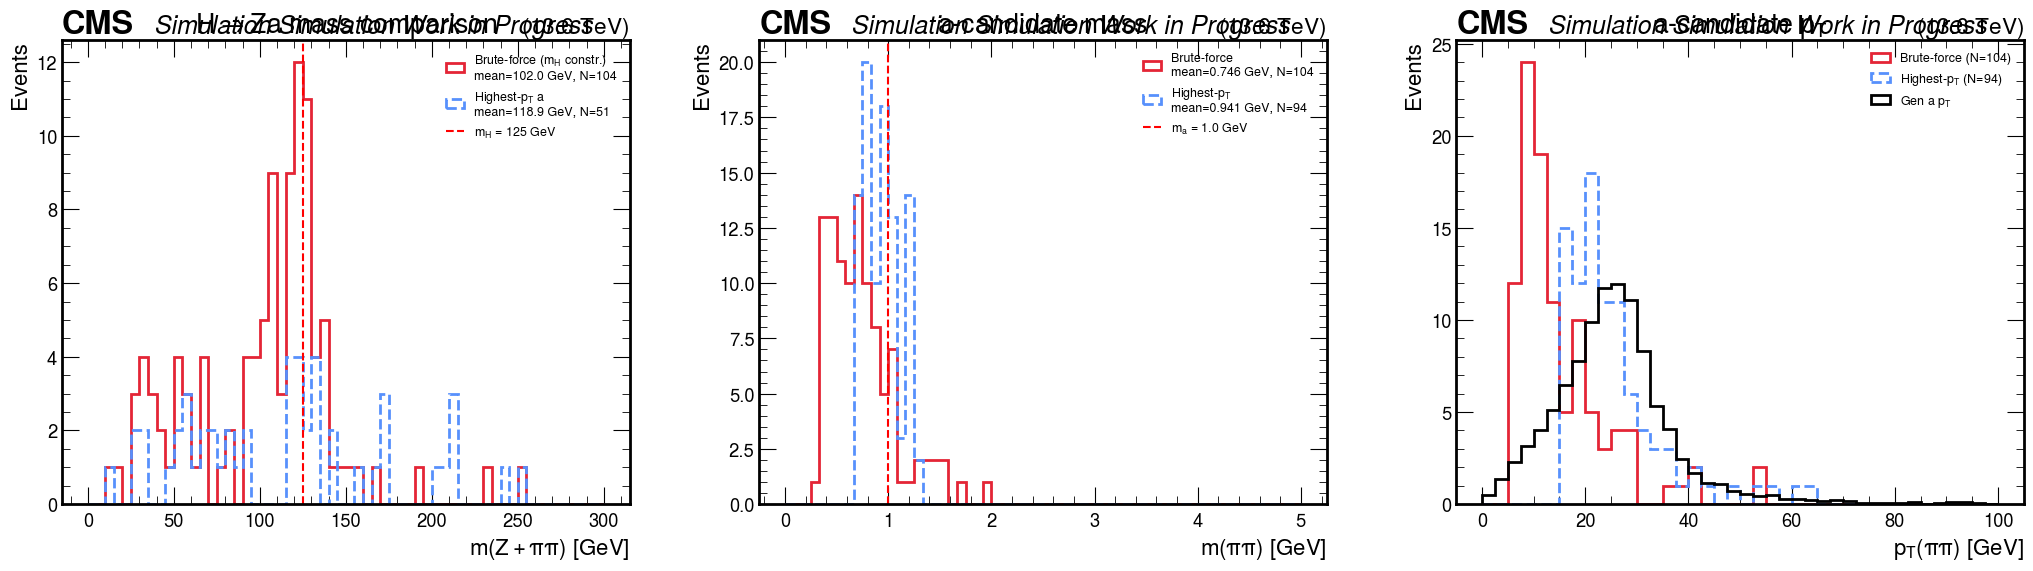

In [39]:
# ── Brute-force H → Za: pick OS pair that gives m(Z+ππ) closest to 125 GeV ──
# Uses argcombinations (proven correct in cell above) + numeric m(H) computation.
import time as _time

M_H = 125.0
_n = len(events)
BF_CHUNK = 2500  # smaller chunks for memory / progress
BF_TRK_PT = 3.0  # per-track pT cut [GeV] to reduce combinatorics

print("Brute-force H→Za: OS pair giving m(Z+ππ) closest to m_H = 125 GeV")
print(f"  Cuts: track pT > {BF_TRK_PT} GeV, OS, ΔR < 0.2")
print("=" * 60)
_t0 = _time.time()

# ── Per-event Z Cartesian components (flat numpy) ────────────────────
z_4v = vector.zip({"pt": z_pt, "eta": z_eta, "phi": z_phi, "mass": z_mass})
has_z_np = ak.to_numpy(has_z)
z_E_np  = ak.to_numpy(z_4v.energy)
z_px_np = ak.to_numpy(z_4v.px)
z_py_np = ak.to_numpy(z_4v.py)
z_pz_np = ak.to_numpy(z_4v.pz)

# ── Reuse in-memory PFCands if available ─────────────────────────────
try:
    _npf = len(clean_pf)
    print(f"  PFCands in memory: {float(ak.mean(ak.num(clean_pf))):.1f} tracks/event")
except NameError:
    print("  Reloading PFCands …")
    pf_data = uproot.concatenate(
        {f: "Events" for f in files}, expressions=pf_branches_to_read, library="ak")
    _pt  = pf_data["PFCands_pt"];  _eta = pf_data["PFCands_eta"]
    _phi = pf_data["PFCands_phi"]; _m   = pf_data["PFCands_mass"]
    _q   = pf_data["PFCands_charge"]
    _pv = (pf_data["PFCands_fromPV"] if "PFCands_fromPV" in pf_data.fields
           else (pf_data["PFCands_pvAssocQuality"] if "PFCands_pvAssocQuality" in pf_data.fields
                 else ak.ones_like(_pt, dtype=int)*3))
    _dz = pf_data["PFCands_dz"] if "PFCands_dz" in pf_data.fields else None
    _d0 = pf_data["PFCands_d0"] if "PFCands_d0" in pf_data.fields else None
    _sel = (_q != 0) & (_pt > 0.5) & (np.abs(_eta) < 2.5) & (_pv >= 1)
    if _dz is not None: _sel = _sel & (np.abs(_dz) < 0.5)
    if _d0 is not None: _sel = _sel & (np.abs(_d0) < 0.1)
    _trk = vector.zip({"pt": _pt[_sel], "eta": _eta[_sel], "phi": _phi[_sel],
                        "mass": ak.full_like(_m[_sel], M_PION)})
    _sq = _q[_sel]
    del pf_data, _pt, _eta, _phi, _m, _q, _pv, _dz, _d0, _sel; gc.collect()
    _nomu = remove_overlap(_trk, sel_mu, dr_cut=0.3)
    _noel = remove_overlap(_trk, sel_el, dr_cut=0.3)
    clean_pf = _trk[_nomu & _noel]; clean_pf_q = _sq[_nomu & _noel]
    del _trk, _sq, _nomu, _noel; gc.collect()
    print(f"  Reloaded: {float(ak.mean(ak.num(clean_pf))):.1f} tracks/event")

# ── Apply per-track pT cut ────────────────────────────────────────────
_mean_before = float(ak.mean(ak.num(clean_pf)))
pt_sel = clean_pf.pt > BF_TRK_PT
bf_pf = clean_pf[pt_sel]
bf_pf_q = clean_pf_q[pt_sel]
_mean_after = float(ak.mean(ak.num(bf_pf)))
print(f"  Track pT > {BF_TRK_PT} GeV: {_mean_before:.1f} → {_mean_after:.1f} tracks/event")
del pt_sel

# ── Output arrays ─────────────────────────────────────────────────────
h_bf_m_np    = np.full(_n, -999.0)
h_bf_pt_np   = np.full(_n, -999.0)
a_bf_mass_np = np.full(_n, -999.0)
a_bf_pt_np   = np.full(_n, -999.0)
a_bf_eta_np  = np.full(_n, -999.0)
a_bf_phi_np  = np.full(_n, -999.0)
has_bf_np    = np.zeros(_n, dtype=bool)

n_collim_total = 0

# ── Chunked loop ──────────────────────────────────────────────────────
for chunk_start in range(0, _n, BF_CHUNK):
    chunk_end = min(chunk_start + BF_CHUNK, _n)
    sl = slice(chunk_start, chunk_end)

    chunk_hasZ = has_z_np[sl]
    if not np.any(chunk_hasZ):
        print(f"  Chunk {chunk_start:>6d}–{chunk_end:<6d}: no Z → skip")
        continue

    chunk_pf = bf_pf[sl]
    chunk_q  = bf_pf_q[sl]

    # All unique pairs (same as cell 27, proven correct)
    pairs = ak.argcombinations(chunk_pf, 2, axis=1)
    n_pairs = int(ak.sum(ak.num(pairs)))
    if n_pairs == 0:
        print(f"  Chunk {chunk_start:>6d}–{chunk_end:<6d}: 0 pairs → skip")
        continue

    i0, i1 = ak.unzip(pairs)
    pf0 = chunk_pf[i0]; pf1 = chunk_pf[i1]
    q0  = chunk_q[i0];  q1  = chunk_q[i1]

    # OS + collimation (no mass-window pre-cut — the H-mass constraint does the work)
    os_mask = (q0 * q1 < 0)
    dr_pair = pf0.deltaR(pf1)
    coll_mask = ak.fill_none(os_mask & (dr_pair < 0.2), False)

    a_cand = pf0[coll_mask] + pf1[coll_mask]
    n_coll = ak.num(a_cand)
    n_coll_np = ak.to_numpy(n_coll)
    n_coll_sum = int(np.sum(n_coll_np))
    n_collim_total += n_coll_sum

    del pairs, i0, i1, pf0, pf1, q0, q1, os_mask, dr_pair, coll_mask

    if n_coll_sum == 0:
        del a_cand; gc.collect()
        print(f"  Chunk {chunk_start:>6d}–{chunk_end:<6d}: {n_pairs:>10,d} pairs → 0 collim. OS")
        continue

    # ── Compute m(Z + ππ) with flat numpy (fast, no vector broadcasting) ──
    aE  = ak.to_numpy(ak.flatten(a_cand.energy))
    apx = ak.to_numpy(ak.flatten(a_cand.px))
    apy = ak.to_numpy(ak.flatten(a_cand.py))
    apz = ak.to_numpy(ak.flatten(a_cand.pz))

    zE  = np.repeat(z_E_np[sl],  n_coll_np)
    zpx = np.repeat(z_px_np[sl], n_coll_np)
    zpy = np.repeat(z_py_np[sl], n_coll_np)
    zpz = np.repeat(z_pz_np[sl], n_coll_np)

    hE = zE + aE;  hpx = zpx + apx;  hpy = zpy + apy;  hpz = zpz + apz
    h_m2 = hE**2 - hpx**2 - hpy**2 - hpz**2
    h_m_flat  = np.sqrt(np.maximum(h_m2, 0.0))
    h_pt_flat = np.sqrt(hpx**2 + hpy**2)

    # Unflatten and pick the pair closest to m_H per event
    h_m_jag  = ak.unflatten(h_m_flat,  n_coll)
    h_pt_jag = ak.unflatten(h_pt_flat, n_coll)
    dm_h_jag = ak.unflatten(np.abs(h_m_flat - M_H), n_coll)

    has_valid = chunk_hasZ & (n_coll_np > 0)
    if np.any(has_valid):
        hv = ak.Array(has_valid)
        dm_safe = ak.where(hv, dm_h_jag, ak.full_like(dm_h_jag, 9999.0))
        best = ak.argmin(dm_safe, axis=1, keepdims=True)

        bv_a   = a_cand[best]
        bv_hm  = h_m_jag[best]
        bv_hpt = h_pt_jag[best]

        has_bf_np[sl]    = has_valid
        h_bf_m_np[sl]    = ak.to_numpy(ak.fill_none(ak.firsts(bv_hm),  -999))
        h_bf_pt_np[sl]   = ak.to_numpy(ak.fill_none(ak.firsts(bv_hpt), -999))
        a_bf_mass_np[sl] = ak.to_numpy(ak.fill_none(ak.firsts(bv_a.mass), -999))
        a_bf_pt_np[sl]   = ak.to_numpy(ak.fill_none(ak.firsts(bv_a.pt),   -999))
        a_bf_eta_np[sl]  = ak.to_numpy(ak.fill_none(ak.firsts(bv_a.eta),  -999))
        a_bf_phi_np[sl]  = ak.to_numpy(ak.fill_none(ak.firsts(bv_a.phi),  -999))

    del a_cand; gc.collect()
    print(f"  Chunk {chunk_start:>6d}–{chunk_end:<6d}: "
          f"{n_pairs:>10,d} pairs → {n_coll_sum:>6,d} collim. OS  [{_time.time()-_t0:.0f}s]")

_dt = _time.time() - _t0
print(f"\n  Done in {_dt:.1f}s  ({n_collim_total:,d} total collimated OS pairs)")

has_bf = has_bf_np.astype(bool) & (h_bf_m_np > 0)
print(f"  Events with brute-force H→Za: {int(np.sum(has_bf))}")
print(f"  cf. previous approach:        {int(ak.sum(has_a_pf_reco & has_z))}")

h_bf_m  = h_bf_m_np[has_bf]
h_bf_pt = h_bf_pt_np[has_bf]
a_bf_m  = a_bf_mass_np[has_bf]
a_bf_pt = a_bf_pt_np[has_bf]

if len(h_bf_m) > 0:
    print(f"\n  Brute-force: mean m(Za) = {np.mean(h_bf_m):.1f} GeV, "
          f"mean m(ππ) = {np.mean(a_bf_m):.3f} GeV, "
          f"mean pT(ππ) = {np.mean(a_bf_pt):.1f} GeV")

# ── Comparison plots ──────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

ax = axes[0]
bins_h = np.linspace(0, 300, 61)
if len(h_bf_m) > 0:
    ax.hist(h_bf_m, bins=bins_h, histtype="step", lw=2, color="C2",
            label=f"Brute-force ($m_H$ constr.)\nmean={np.mean(h_bf_m):.1f} GeV, N={len(h_bf_m)}")
if len(h_pf_m) > 0:
    ax.hist(h_pf_m, bins=bins_h, histtype="step", lw=2, color="C0", ls="--",
            label=f"Highest-$p_T$ $a$\nmean={np.mean(h_pf_m):.1f} GeV, N={len(h_pf_m)}")
ax.axvline(M_H, color="red", ls="--", lw=1.5, label="$m_H$ = 125 GeV")
ax.set_xlabel("$m(Z + \\pi\\pi)$ [GeV]"); ax.set_ylabel("Events")
ax.set_title("$H \\to Za$ mass comparison"); ax.legend(fontsize=9); cms_label(ax)

ax = axes[1]
if len(a_bf_m) > 0:
    ax.hist(a_bf_m, bins=60, range=(0, 5), histtype="step", lw=2, color="C2",
            label=f"Brute-force\nmean={np.mean(a_bf_m):.3f} GeV, N={len(a_bf_m)}")
if len(m_pf) > 0:
    ax.hist(m_pf, bins=60, range=(0, 5), histtype="step", lw=2, color="C0", ls="--",
            label=f"Highest-$p_T$\nmean={np.mean(m_pf):.3f} GeV, N={len(m_pf)}")
ax.axvline(MASS_A, color="red", ls="--", lw=1.5, label=f"$m_a$ = {MASS_A} GeV")
ax.set_xlabel("$m(\\pi\\pi)$ [GeV]"); ax.set_ylabel("Events")
ax.set_title("$a$-candidate mass"); ax.legend(fontsize=9); cms_label(ax)

ax = axes[2]
bins_apt = np.linspace(0, 100, 41)
if len(a_bf_pt) > 0:
    ax.hist(a_bf_pt, bins=bins_apt, histtype="step", lw=2, color="C2",
            label=f"Brute-force (N={len(a_bf_pt)})")
if len(pt_pf) > 0:
    ax.hist(pt_pf, bins=bins_apt, histtype="step", lw=2, color="C0", ls="--",
            label=f"Highest-$p_T$ (N={len(pt_pf)})")
gen_a_pt_valid = ak.to_numpy(ak.flatten(gen_a_vec.pt, axis=None))
w = np.full(len(gen_a_pt_valid), max(len(a_bf_pt), 1) / max(len(gen_a_pt_valid), 1))
ax.hist(gen_a_pt_valid, bins=bins_apt, histtype="step", lw=2, color="black",
        label="Gen $a$ $p_T$", weights=w)
ax.set_xlabel("$p_T(\\pi\\pi)$ [GeV]"); ax.set_ylabel("Events")
ax.set_title("$a$-candidate $p_T$"); ax.legend(fontsize=9); cms_label(ax)

save_and_show(fig, "pfcands_hza_bruteforce.png")

## Jet and MET Distributions

Basic jet and missing transverse energy distributions. Jets arise mainly from ISR/FSR activity.

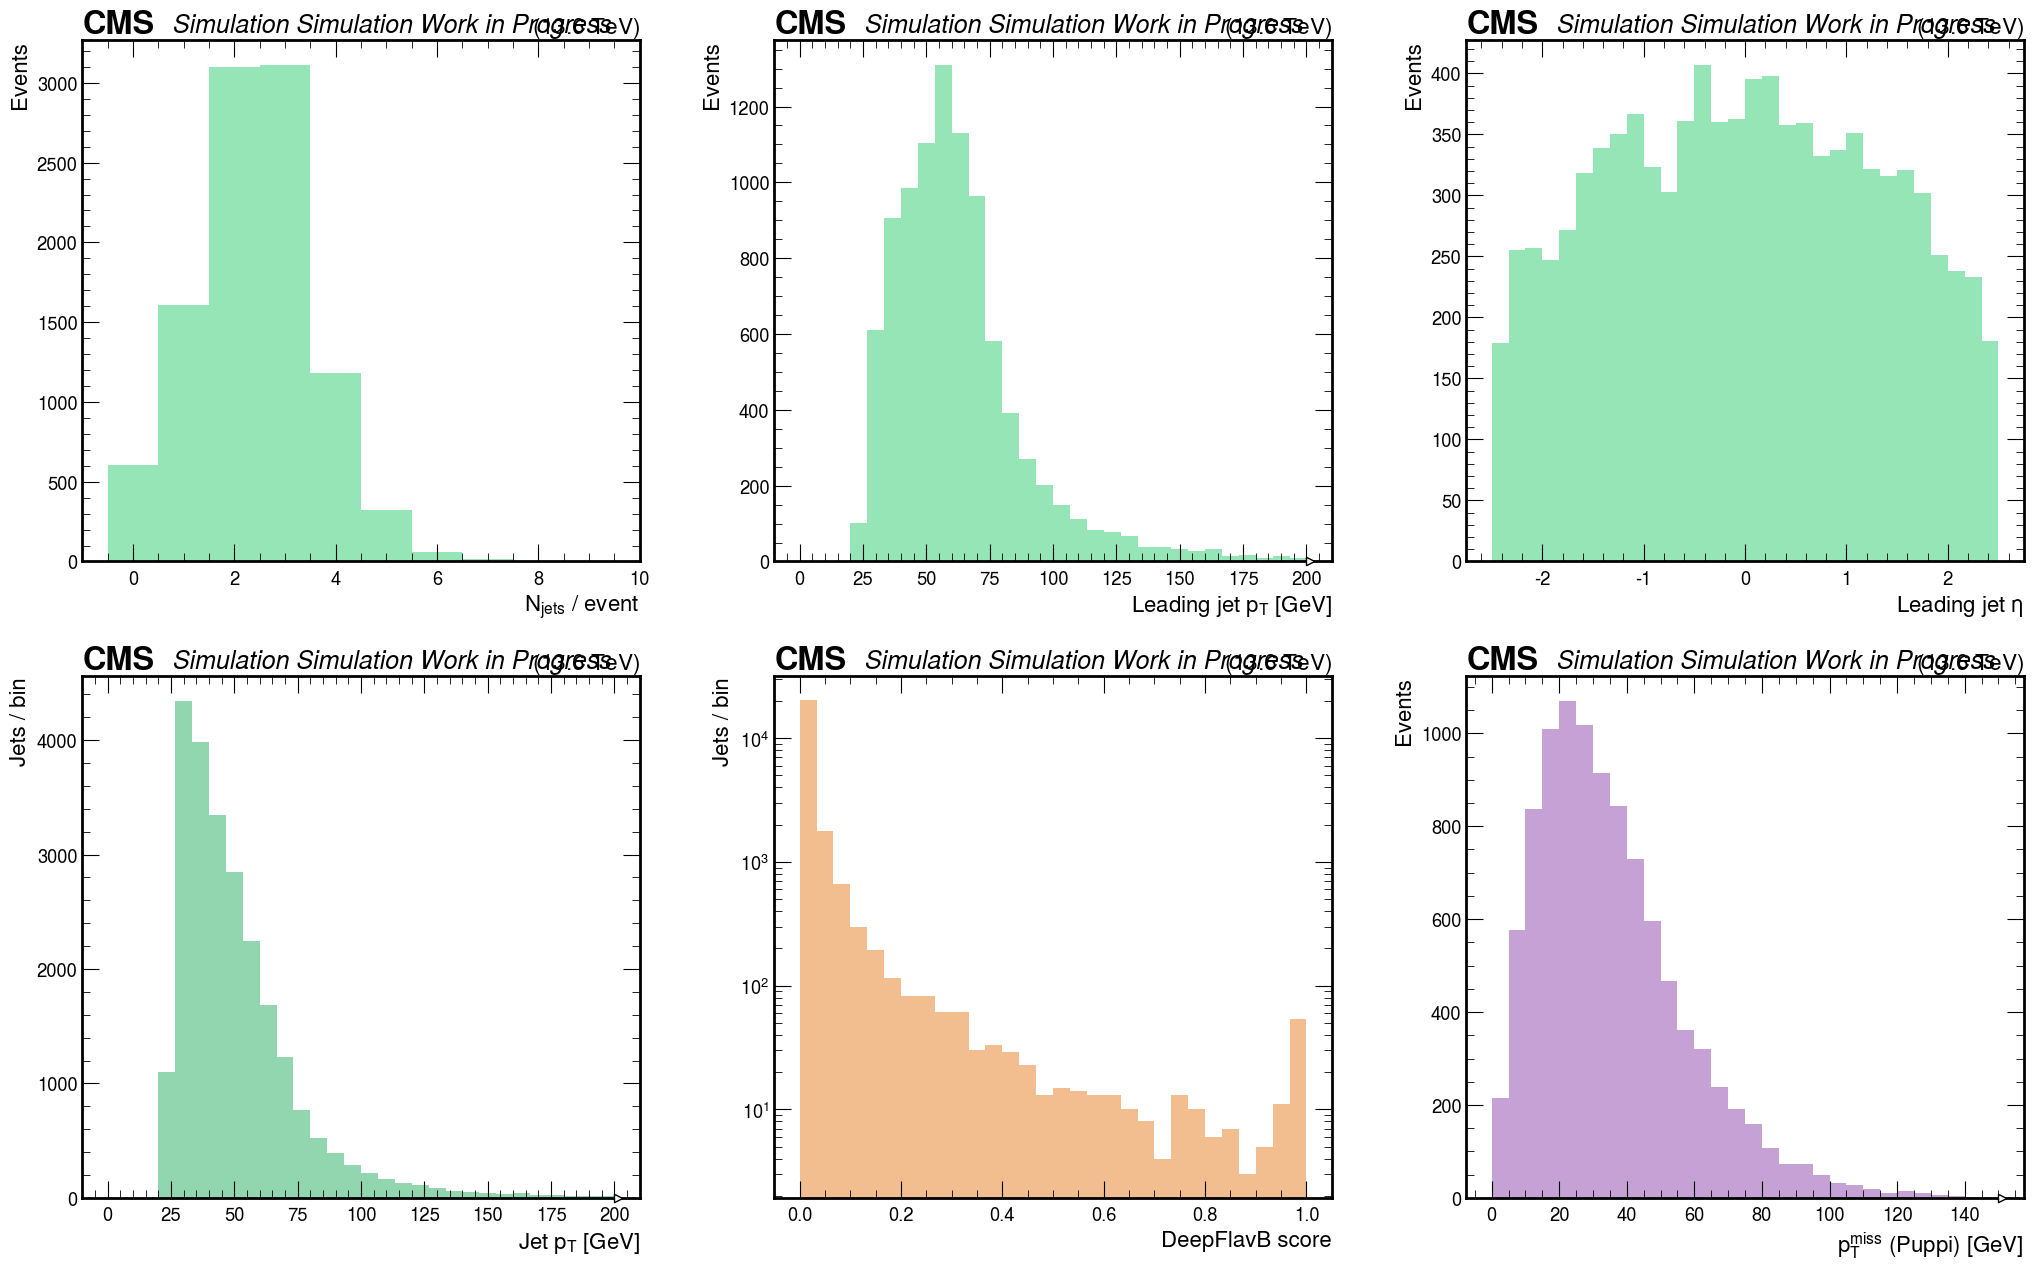

In [40]:
# ── Jet and MET plots ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(21, 13))

# Jet multiplicity
h = hist.Hist(hist.axis.Regular(10, -0.5, 9.5, label=r"$N_{\mathrm{jets}}$ / event"))
h.fill(ak.to_numpy(n_jet))
hep.histplot(h, ax=axes[0, 0], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71")
axes[0, 0].set_ylabel("Events")
cms_label(axes[0, 0])

# Leading jet pT
lead_jet_pt = ak.fill_none(ak.firsts(sel_jets.pt), -1)
has_jet = lead_jet_pt > 0
h = hist.Hist(hist.axis.Regular(30, 0, 200, label=r"Leading jet $p_T$ [GeV]"))
h.fill(ak.to_numpy(lead_jet_pt[has_jet]))
hep.histplot(h, ax=axes[0, 1], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71")
axes[0, 1].set_ylabel("Events")
cms_label(axes[0, 1])

# Leading jet eta
lead_jet_eta = ak.fill_none(ak.firsts(sel_jets.eta), -99)
h = hist.Hist(hist.axis.Regular(30, -2.5, 2.5, label=r"Leading jet $\eta$"))
h.fill(ak.to_numpy(lead_jet_eta[has_jet]))
hep.histplot(h, ax=axes[0, 2], histtype="fill", alpha=0.5, color="#2ecc71", edgecolor="#2ecc71")
axes[0, 2].set_ylabel("Events")
cms_label(axes[0, 2])

# All jet pT
all_jet_pt = ak.flatten(sel_jets.pt).to_numpy()
h = hist.Hist(hist.axis.Regular(30, 0, 200, label=r"Jet $p_T$ [GeV]"))
h.fill(all_jet_pt)
hep.histplot(h, ax=axes[1, 0], histtype="fill", alpha=0.5, color="#27ae60", edgecolor="#27ae60")
axes[1, 0].set_ylabel("Jets / bin")
cms_label(axes[1, 0])

# b-tag score (DeepFlavour)
all_btag = ak.flatten(sel_jet_btag).to_numpy()
h = hist.Hist(hist.axis.Regular(30, 0, 1, label="DeepFlavB score"))
h.fill(all_btag)
hep.histplot(h, ax=axes[1, 1], histtype="fill", alpha=0.5, color="#e67e22", edgecolor="#e67e22")
axes[1, 1].set_ylabel("Jets / bin")
axes[1, 1].set_yscale("log")
cms_label(axes[1, 1])

# PuppiMET
met_pt = ak.to_numpy(events.PuppiMET_pt)
h = hist.Hist(hist.axis.Regular(30, 0, 150, label=r"$p_T^{\mathrm{miss}}$ (Puppi) [GeV]"))
h.fill(met_pt)
hep.histplot(h, ax=axes[1, 2], histtype="fill", alpha=0.5, color="#8e44ad", edgecolor="#8e44ad")
axes[1, 2].set_ylabel("Events")
cms_label(axes[1, 2])

save_and_show(fig, "reco_jets_met.png")

## Event-Level Observables

Scalar sum of jet $p_T$ ($H_T$), total visible transverse momentum, and combined event-level quantities.

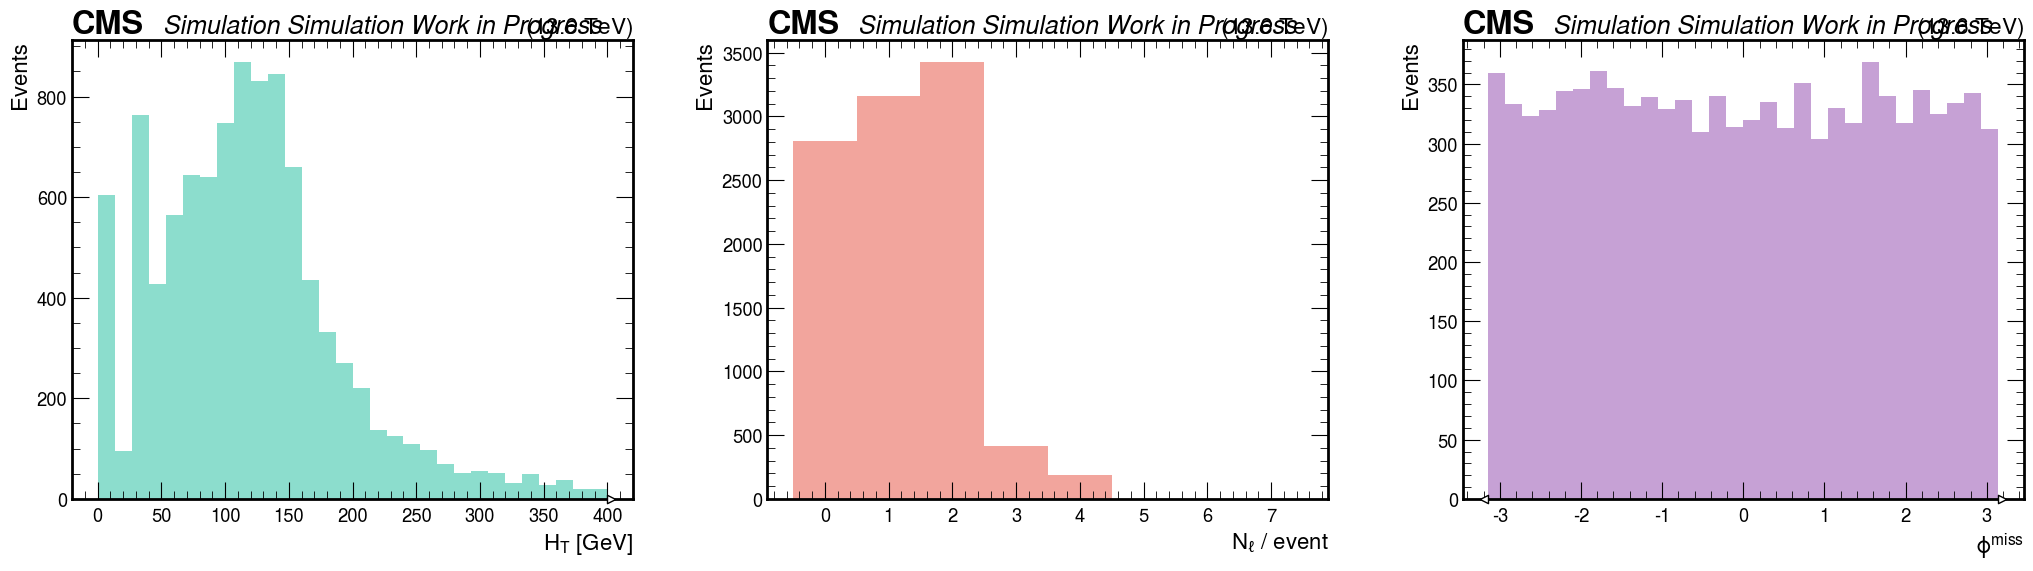

In [41]:
# ── Event-level observables ────────────────────────────────────────────────────
# HT = scalar sum of jet pT
ht = ak.sum(sel_jets.pt, axis=1)

# Total lepton multiplicity
n_lep_total = n_mu + n_el

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# HT
h = hist.Hist(hist.axis.Regular(30, 0, 400, label=r"$H_T$ [GeV]"))
h.fill(ak.to_numpy(ht))
hep.histplot(h, ax=axes[0], histtype="fill", alpha=0.5, color="#1abc9c", edgecolor="#1abc9c")
axes[0].set_ylabel("Events")
cms_label(axes[0])

# Total lepton multiplicity
h = hist.Hist(hist.axis.Regular(8, -0.5, 7.5, label=r"$N_{\ell}$ / event"))
h.fill(ak.to_numpy(n_lep_total))
hep.histplot(h, ax=axes[1], histtype="fill", alpha=0.5, color="#e74c3c", edgecolor="#e74c3c")
axes[1].set_ylabel("Events")
cms_label(axes[1])

# MET phi
met_phi = ak.to_numpy(events.PuppiMET_phi)
h = hist.Hist(hist.axis.Regular(30, -np.pi, np.pi, label=r"$\phi^{\mathrm{miss}}$"))
h.fill(met_phi)
hep.histplot(h, ax=axes[2], histtype="fill", alpha=0.5, color="#8e44ad", edgecolor="#8e44ad")
axes[2].set_ylabel("Events")
cms_label(axes[2])

save_and_show(fig, "event_level.png")

## Generator vs Reconstruction Comparison

Compare gen-level and reco-level Z boson mass and $p_T$ to assess reconstruction performance.

/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer wei

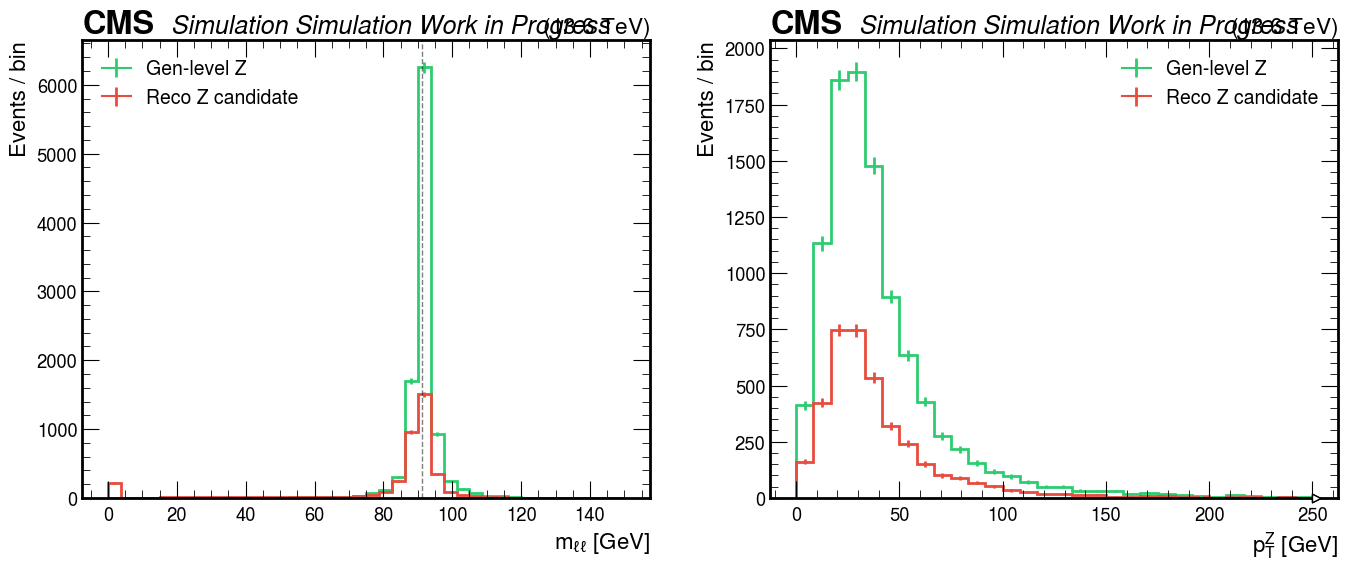

In [42]:
# ── Gen vs Reco comparison ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Z mass: gen vs reco
h_gen = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_reco = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_gen.fill(z_m)
h_reco.fill(z_mass_arr)
hep.histplot(h_gen, ax=axes[0], histtype="step", linewidth=2, color="#2ecc71", label="Gen-level Z")
hep.histplot(h_reco, ax=axes[0], histtype="step", linewidth=2, color="#e74c3c", label="Reco Z candidate")
axes[0].axvline(91.2, color="black", linestyle="--", linewidth=1, alpha=0.5)
axes[0].set_ylabel("Events / bin")
axes[0].legend(fontsize=14)
cms_label(axes[0])

# Z pT: gen vs reco
h_gen_pt = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h_reco_pt = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h_gen_pt.fill(z_pt_gen := ak.flatten(gen_Z.pt).to_numpy())
h_reco_pt.fill(z_pt_arr)
hep.histplot(h_gen_pt, ax=axes[1], histtype="step", linewidth=2, color="#2ecc71", label="Gen-level Z")
hep.histplot(h_reco_pt, ax=axes[1], histtype="step", linewidth=2, color="#e74c3c", label="Reco Z candidate")
axes[1].set_ylabel("Events / bin")
axes[1].legend(fontsize=14)
cms_label(axes[1])

save_and_show(fig, "gen_vs_reco_z.png")

/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1071: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1071: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1071: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1071: UserWarning: Integer wei

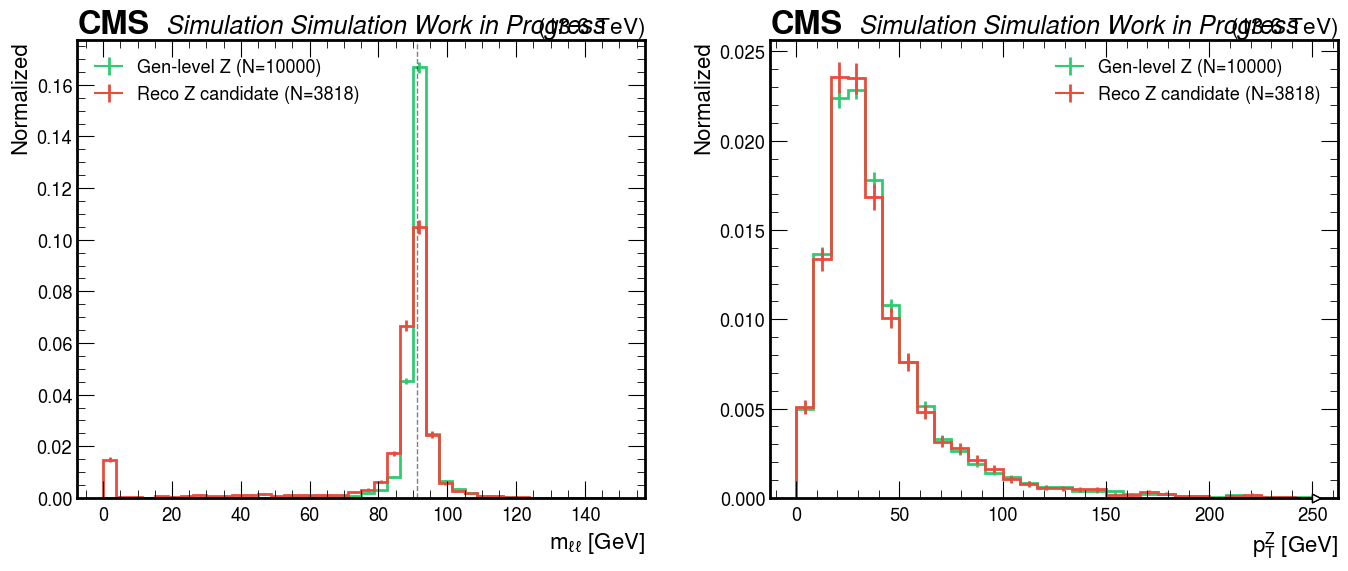

In [43]:
# ── Gen vs Reco comparison (normalized to unit area) ───────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Z mass: gen vs reco (normalized)
h_gen_n = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_reco_n = hist.Hist(hist.axis.Regular(40, 0, 150, label=r"$m_{\ell\ell}$ [GeV]"))
h_gen_n.fill(z_m)
h_reco_n.fill(z_mass_arr)
hep.histplot(h_gen_n, ax=axes[0], histtype="step", linewidth=2, color="#2ecc71",
             label=f"Gen-level Z (N={len(z_m)})", density=True)
hep.histplot(h_reco_n, ax=axes[0], histtype="step", linewidth=2, color="#e74c3c",
             label=f"Reco Z candidate (N={len(z_mass_arr)})", density=True)
axes[0].axvline(91.2, color="black", linestyle="--", linewidth=1, alpha=0.5)
axes[0].set_ylabel("Normalized")
axes[0].legend(fontsize=13)
cms_label(axes[0])

# Z pT: gen vs reco (normalized)
h_gen_pt_n = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h_reco_pt_n = hist.Hist(hist.axis.Regular(30, 0, 250, label=r"$p_T^{Z}$ [GeV]"))
h_gen_pt_n.fill(z_pt_gen)
h_reco_pt_n.fill(z_pt_arr)
hep.histplot(h_gen_pt_n, ax=axes[1], histtype="step", linewidth=2, color="#2ecc71",
             label=f"Gen-level Z (N={len(z_pt_gen)})", density=True)
hep.histplot(h_reco_pt_n, ax=axes[1], histtype="step", linewidth=2, color="#e74c3c",
             label=f"Reco Z candidate (N={len(z_pt_arr)})", density=True)
axes[1].set_ylabel("Normalized")
axes[1].legend(fontsize=13)
cms_label(axes[1])

save_and_show(fig, "gen_vs_reco_z_normalized.png")

## BPH NanoAOD Validation

The BPH NanoAOD format adds dedicated B-physics collections on top of standard NanoAOD.
For the H → Za analysis, the key collections are:

| Collection | Content | Relevance for a → μμ |
|------------|---------|----------------------|
| **MuMu** | Opposite-sign dimuon pairs with vertex fit | Direct a → μμ candidates |
| **Track** | Merged `packedPFCandidates` + `lostTracks` with BPH selection | Tracks near dimuon vertex |
| **Kshort** | K_S → π⁺π⁻ candidates | Background / control |
| **BPHGenPart** | Gen-level B-hadron decay chains | MC truth |

This section loads BPH NanoAOD files independently and validates the dimuon and track collections.

In [44]:
# ── Load BPH NanoAOD ───────────────────────────────────────────────────────────
import glob
import uproot

BPH_DIR = "/eos/user/p/pgadow/www/share/ggH_HZa_mA1_0GeV/bphnano/"

bph_files = sorted(glob.glob(BPH_DIR + "*.root"))
print(f"BPH NanoAOD files found: {len(bph_files)}")

BPH_MAX_FILES = 5  # Use a subset to keep things manageable
bph_files_use = bph_files[:BPH_MAX_FILES] if BPH_MAX_FILES else bph_files
print(f"Using {len(bph_files_use)} files for validation")

# Inspect available branches in one file
with uproot.open(bph_files_use[0]) as f:
    tree = f["Events"]
    bph_keys = sorted(tree.keys())

# Identify BPH-specific collections
bph_collections = {}
for k in bph_keys:
    prefix = k.split("_")[0] if "_" in k else k
    if prefix not in bph_collections:
        bph_collections[prefix] = 0
    bph_collections[prefix] += 1

# Print BPH-specific collections (not in standard NanoAOD)
bph_specific = ["MuMu", "Track", "MuonBPH", "Kshort", "Lambda", "BToKMuMu",
                 "BToTrkTrkMuMu", "DiTrack", "BToKshortMuMu", "BPHGenPart",
                 "LambdabToLambdaMuMu", "BToChargedKstar", "XibToXi", "BPHPV"]
print("\nBPH-specific collections:")
for coll in bph_specific:
    n = bph_collections.get(coll, 0)
    if n > 0:
        print(f"  {coll:30s} {n:3d} branches")
    else:
        # Check with 'n' prefix
        n_key = f"n{coll}"
        if n_key in bph_keys:
            print(f"  {coll:30s} (counter only)")

print(f"\nTotal branches: {len(bph_keys)}")

BPH NanoAOD files found: 100
Using 5 files for validation

BPH-specific collections:
  MuMu                            18 branches
  Track                           32 branches
  Kshort                          40 branches
  Lambda                          40 branches
  BToKMuMu                        55 branches
  BToTrkTrkMuMu                   74 branches
  DiTrack                         30 branches
  BToKshortMuMu                   76 branches
  BPHGenPart                      11 branches
  LambdabToLambdaMuMu             76 branches

Total branches: 2698


In [45]:
# ── Load BPH NanoAOD core branches ─────────────────────────────────────────────
bph_branches = [
    # MuMu (dimuon candidates with vertex fit)
    "nMuMu", "MuMu_mass", "MuMu_pt", "MuMu_eta", "MuMu_phi",
    "MuMu_charge", "MuMu_svprob", "MuMu_DCA",
    "MuMu_l1_idx", "MuMu_l2_idx",
    # MuonBPH (may not exist in all BPH NanoAOD configs)
    "nMuonBPH", "MuonBPH_pt", "MuonBPH_eta", "MuonBPH_phi", "MuonBPH_mass",
    "MuonBPH_charge", "MuonBPH_dxy",
    # Track (merged PF + lost tracks)
    "nTrack", "Track_pt", "Track_eta", "Track_phi", "Track_mass",
    "Track_charge", "Track_dxy", "Track_dz", "Track_DCASig",
    "Track_isPacked", "Track_isLostTrk", "Track_isMatchedToMuon",
    # Standard Muon (for Z reconstruction)
    "nMuon", "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass",
    "Muon_charge", "Muon_mediumId", "Muon_pfRelIso04_all",
    # Standard Electron (for Z reconstruction)
    "nElectron", "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass",
    "Electron_charge", "Electron_cutBased",
    # GenPart for truth matching
    "nGenPart", "GenPart_pt", "GenPart_eta", "GenPart_phi", "GenPart_mass",
    "GenPart_pdgId", "GenPart_status", "GenPart_genPartIdxMother",
]

# Filter to branches that actually exist
bph_branches_exist = [b for b in bph_branches if b in bph_keys]
missing = set(bph_branches) - set(bph_branches_exist)
if missing:
    print(f"⚠ Missing branches (skipped): {missing}")

bph_events = uproot.concatenate(
    {f: "Events" for f in bph_files_use},
    expressions=bph_branches_exist,
    library="ak",
)

has_muonbph = "nMuonBPH" in ak.fields(bph_events)

print(f"BPH NanoAOD events loaded: {len(bph_events)}")
print(f"  MuMu candidates/event:  mean={ak.mean(bph_events['nMuMu']):.1f}, max={ak.max(bph_events['nMuMu'])}")
print(f"  Tracks/event:            mean={ak.mean(bph_events['nTrack']):.1f}, max={ak.max(bph_events['nTrack'])}")
if has_muonbph:
    print(f"  MuonBPH/event:           mean={ak.mean(bph_events['nMuonBPH']):.1f}, max={ak.max(bph_events['nMuonBPH'])}")
else:
    print(f"  MuonBPH collection:      not present in this BPH NanoAOD config")
if "nMuon" in ak.fields(bph_events):
    print(f"  Muon (std)/event:        mean={ak.mean(bph_events['nMuon']):.1f}, max={ak.max(bph_events['nMuon'])}")
if "nElectron" in ak.fields(bph_events):
    print(f"  Electron (std)/event:    mean={ak.mean(bph_events['nElectron']):.1f}, max={ak.max(bph_events['nElectron'])}")

⚠ Missing branches (skipped): {'MuonBPH_dxy', 'nMuonBPH', 'MuonBPH_mass', 'MuMu_DCA', 'MuonBPH_charge', 'MuonBPH_eta', 'MuonBPH_pt', 'MuonBPH_phi'}
BPH NanoAOD events loaded: 5000
  MuMu candidates/event:  mean=0.1, max=2
  Tracks/event:            mean=7.6, max=281
  MuonBPH collection:      not present in this BPH NanoAOD config
  Muon (std)/event:        mean=1.1, max=8
  Electron (std)/event:    mean=0.9, max=6


### Track Collection: BPH Tracks

The BPH `Track` collection merges `packedPFCandidates` and `lostTracks` with `pt > 0.7 GeV`, `|η| < 3.0`,
and dz compatibility with a dimuon vertex. This is much smaller than the full `PFCands` collection but
includes lost tracks that may be useful for displaced vertex studies.

Total BPH tracks: 38,076
  from packedPFCandidates: 37,173 (97.6%)
  from lostTracks:         903 (2.4%)
  matched to muon:         29 (0.1%)


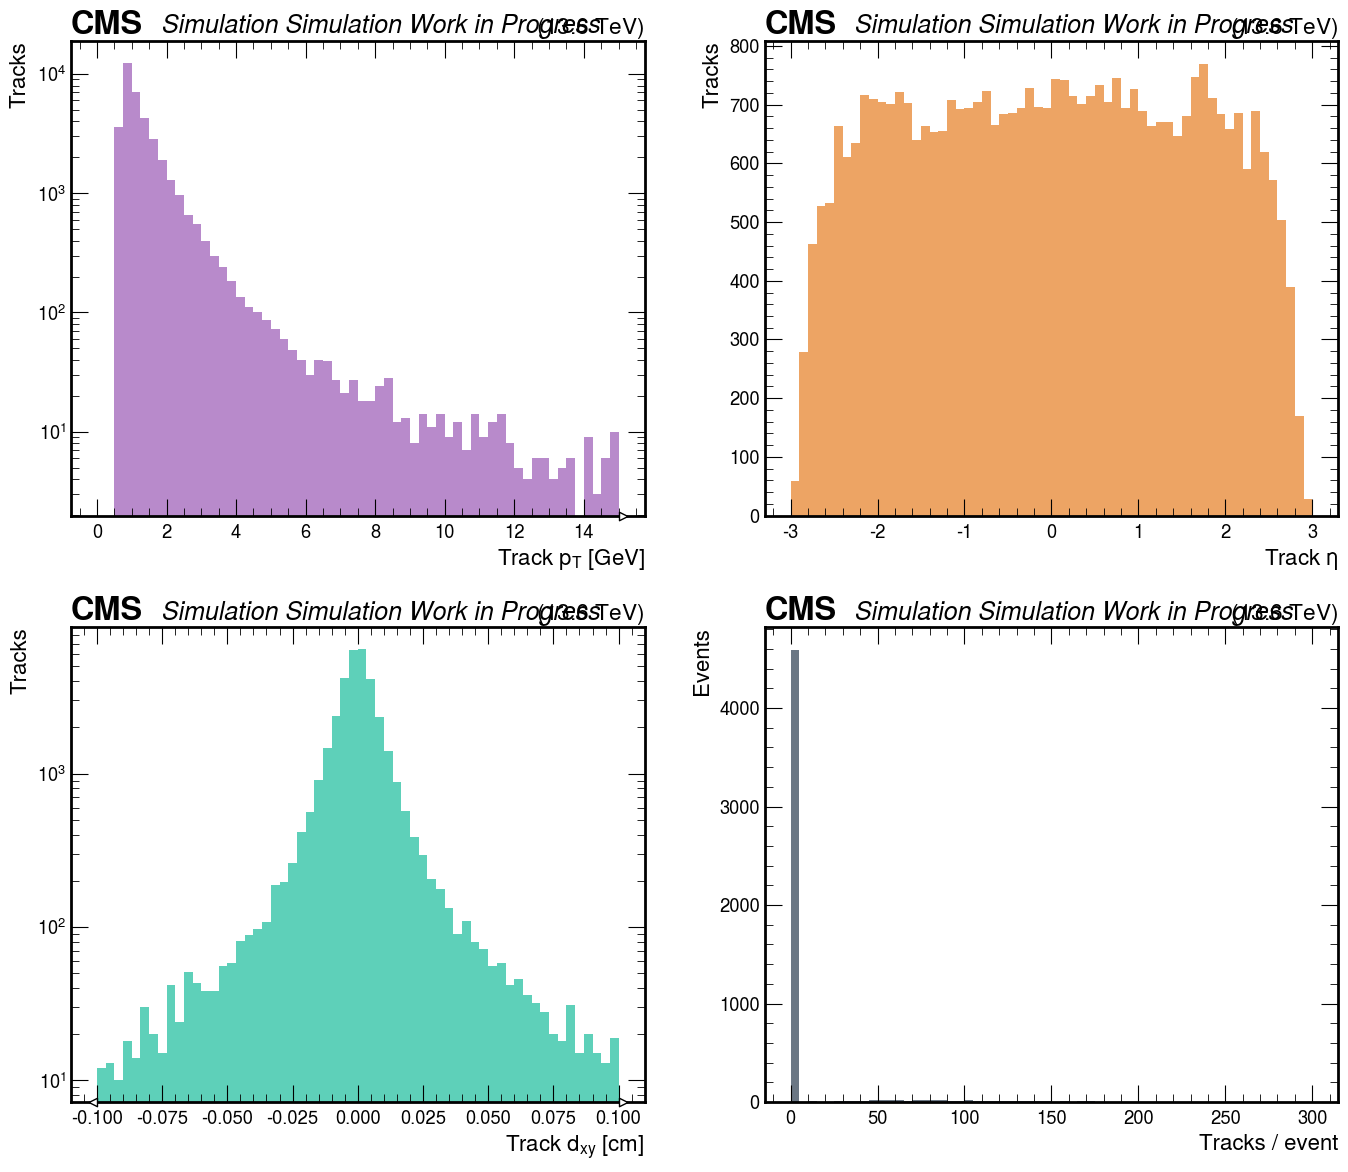

In [46]:
# ── Track collection properties ────────────────────────────────────────────────
trk_pt = ak.flatten(bph_events["Track_pt"])
trk_eta = ak.flatten(bph_events["Track_eta"])
trk_charge = ak.flatten(bph_events["Track_charge"])
trk_dxy = ak.flatten(bph_events["Track_dxy"])
trk_dz = ak.flatten(bph_events["Track_dz"])
trk_isPacked = ak.flatten(bph_events["Track_isPacked"])
trk_isLost = ak.flatten(bph_events["Track_isLostTrk"])
trk_isMuon = ak.flatten(bph_events["Track_isMatchedToMuon"])

print(f"Total BPH tracks: {len(trk_pt):,}")
print(f"  from packedPFCandidates: {ak.sum(trk_isPacked):,} ({100*ak.mean(trk_isPacked):.1f}%)")
print(f"  from lostTracks:         {ak.sum(trk_isLost):,} ({100*ak.mean(trk_isLost):.1f}%)")
print(f"  matched to muon:         {ak.sum(trk_isMuon):,} ({100*ak.mean(trk_isMuon):.1f}%)")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Track pt
h_trk_pt = hist.Hist(hist.axis.Regular(60, 0, 15, label=r"Track $p_T$ [GeV]"))
h_trk_pt.fill(trk_pt)
hep.histplot(h_trk_pt, ax=axes[0, 0], histtype="fill", color="#9b59b6", alpha=0.7)
axes[0, 0].set_ylabel("Tracks")
axes[0, 0].set_yscale("log")
cms_label(axes[0, 0])

# Track eta
h_trk_eta = hist.Hist(hist.axis.Regular(60, -3, 3, label=r"Track $\eta$"))
h_trk_eta.fill(trk_eta)
hep.histplot(h_trk_eta, ax=axes[0, 1], histtype="fill", color="#e67e22", alpha=0.7)
axes[0, 1].set_ylabel("Tracks")
cms_label(axes[0, 1])

# Track dxy
h_trk_dxy = hist.Hist(hist.axis.Regular(60, -0.1, 0.1, label=r"Track $d_{xy}$ [cm]"))
h_trk_dxy.fill(trk_dxy)
hep.histplot(h_trk_dxy, ax=axes[1, 0], histtype="fill", color="#1abc9c", alpha=0.7)
axes[1, 0].set_ylabel("Tracks")
axes[1, 0].set_yscale("log")
cms_label(axes[1, 0])

# Tracks per event
h_ntrk = hist.Hist(hist.axis.Regular(60, 0, 300, label="Tracks / event"))
h_ntrk.fill(bph_events["nTrack"])
hep.histplot(h_ntrk, ax=axes[1, 1], histtype="fill", color="#2c3e50", alpha=0.7)
axes[1, 1].set_ylabel("Events")
cms_label(axes[1, 1])

save_and_show(fig, "bphnano_tracks.png")

/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/afs/cern.ch/work/p/pgadow/cms/analysis/hza/signals/.venv/lib64/python3.12/site-packages/mplhep/_utils.py:1111: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()


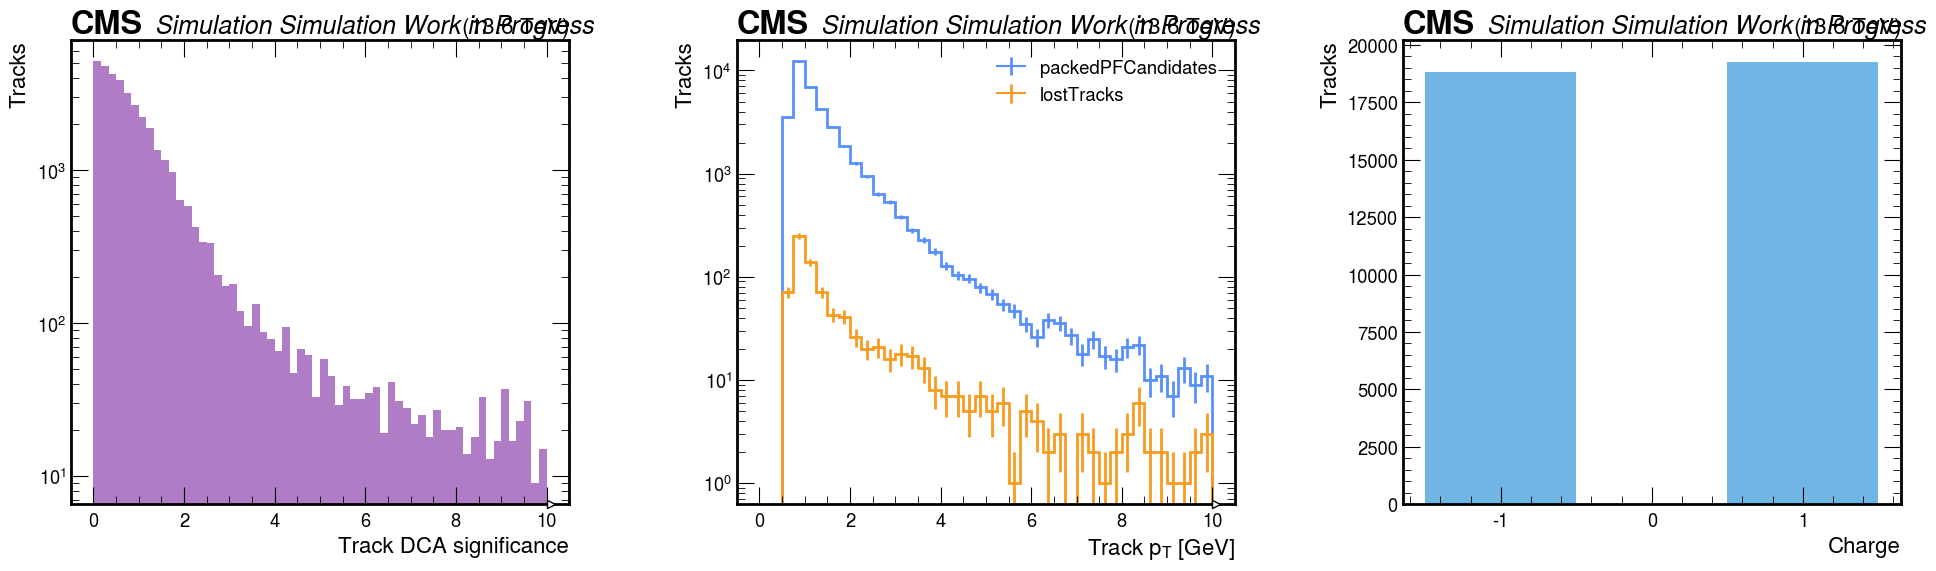

In [47]:
# ── Track DCA significance & source breakdown ─────────────────────────────────
trk_dcasig = ak.flatten(bph_events["Track_DCASig"])

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# DCA significance
h_dcasig = hist.Hist(hist.axis.Regular(60, 0, 10, label=r"Track DCA significance"))
h_dcasig.fill(trk_dcasig)
hep.histplot(h_dcasig, ax=axes[0], histtype="fill", color="#8e44ad", alpha=0.7)
axes[0].set_ylabel("Tracks")
axes[0].set_yscale("log")
cms_label(axes[0])

# Source breakdown: packed vs lostTrack
h_pt_packed = hist.Hist(hist.axis.Regular(40, 0, 10, label=r"Track $p_T$ [GeV]"))
h_pt_lost = hist.Hist(hist.axis.Regular(40, 0, 10, label=r"Track $p_T$ [GeV]"))
h_pt_packed.fill(trk_pt[trk_isPacked == 1])
h_pt_lost.fill(trk_pt[trk_isLost == 1])
hep.histplot([h_pt_packed, h_pt_lost], ax=axes[1],
             label=["packedPFCandidates", "lostTracks"],
             histtype="step", linewidth=2)
axes[1].set_ylabel("Tracks")
axes[1].set_yscale("log")
axes[1].legend()
cms_label(axes[1])

# Charge distribution
h_q = hist.Hist(hist.axis.IntCategory([-1, 0, 1], label="Charge"))
h_q.fill(trk_charge)
hep.histplot(h_q, ax=axes[2], histtype="fill", color="#3498db", alpha=0.7)
axes[2].set_ylabel("Tracks")
cms_label(axes[2])

save_and_show(fig, "bphnano_tracks_detail.png")